# 1. Загрузка данных

## 1.1. Распакуем архив

In [ ]:
!unzip data_input4.zip

Archive:  data_input4.zip
   creating: data_input4/
   creating: data_input4/01_healthy/
  inflating: data_input4/01_healthy/cortex_patient13012020_633nm_obj20_power100_1sec_acc40_сenter2900_place1_20201009_1.txt  
  inflating: data_input4/01_healthy/cortex_patient13012020_633nm_obj20_power100_1sec_сenter2900_place1_20201009_1.txt  
  inflating: data_input4/01_healthy/cortex_patient15012020_633nm_obj20_power100_1sec_acc1_сenter2900_place1_20210202.txt  
  inflating: data_input4/01_healthy/cortex_patient15012020_633nm_obj20_power100_1sec_acc1_сenter2900_place2_20210202.txt  
  inflating: data_input4/01_healthy/cortex_patient180219_633nm_obj50_power100_1sec_acc40_сenter2900_place10_20200813_1.txt  
  inflating: data_input4/01_healthy/cortex_patient180219_633nm_obj50_power100_1sec_acc40_сenter2900_place1_20200813_1.txt  
  inflating: data_input4/01_healthy/cortex_patient180219_633nm_obj50_power100_1sec_acc40_сenter2900_place2_20200813_1.txt  
  inflating: data_input4/01_healthy/cortex_pat

## 1.2. Произведем предобработку данных

In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

In [ ]:
root_folder = "data_input4"
all_files = {}
for fld in next(os.walk(root_folder))[1]:
    path = os.path.join(root_folder, fld)
    all_files[fld] = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

In [ ]:
measurements = []
classifications = []

count_healhy = 0
count_sick = 0

for sample in list(all_files):
    for txt in all_files[sample]:
        if "DS_Store" not in str(txt):
            df = pd.read_csv(os.path.join(root_folder,sample,txt), sep='\t',skiprows=[0],
                header=None, names=[ 'Wave', 'Intensity'])
        #time_unique = df.Wave.unique()
            if len(df[['Intensity']].to_numpy()) != 994:
                measurements.append(df[['Intensity']].to_numpy())
                if 'healthy' in str(sample):
                    classifications.append([1,0])
                    count_healhy += 1
                if 'sick' in str(sample):
                    classifications.append([0,1])
                    count_sick += 1

print(f'Здоровые ткани: {count_healhy}')
print(f'Больные ткани: {count_sick}')
print(f'Все ткани: {count_healhy + count_sick}')

Здоровые ткани: 432
Больные ткани: 122
Все ткани: 554


Загрузим дополнительные данные

In [ ]:
add_data = "image_tumor_patient20022019_633nm_obj20_power100_1sec_сenter2900.txt"

add_data = pd.read_csv(add_data, sep='\t',skiprows=[0], header=None)

for i in range(468):
    measurements.append(add_data.loc[i : i + 1014][3].to_numpy().reshape(-1, 1))
    classifications.append([0, 1])
    count_sick += 1

print(f'Здоровые ткани: {count_healhy}')
print(f'Больные ткани: {count_sick}')
print(f'Все ткани: {count_healhy + count_sick}')

Здоровые ткани: 432
Больные ткани: 590
Все ткани: 1022


# 2. Анализ данных

Подготовим данные

In [ ]:
X = np.array(measurements)
y = np.array(classifications)

In [ ]:
X.shape

(1022, 1015, 1)

In [ ]:
X = X.reshape(1022, 1015)
X.shape

(1022, 1015)

Сделаем чтобы столбцами стали наши длины волны (Raman Shifts)

In [ ]:
raman_shifts = pd.read_csv('/content/data_input4/01_healthy/cortex_patient180219_633nm_obj50_power100_1sec_acc40_сenter2900_place7_20200813_1.txt', sep="\t", header=None)
raman_shifts.drop(columns=[2], inplace = True)
raman_shifts.columns = ["Raman Shifts", "Интенсивность"]
raman_shifts.drop(raman_shifts.head(1).index, inplace=True)
raman_shifts["Raman Shifts"] = pd.to_numeric(raman_shifts["Raman Shifts"], errors='coerce').astype(np.int64)

<Axes: xlabel='Raman Shifts'>

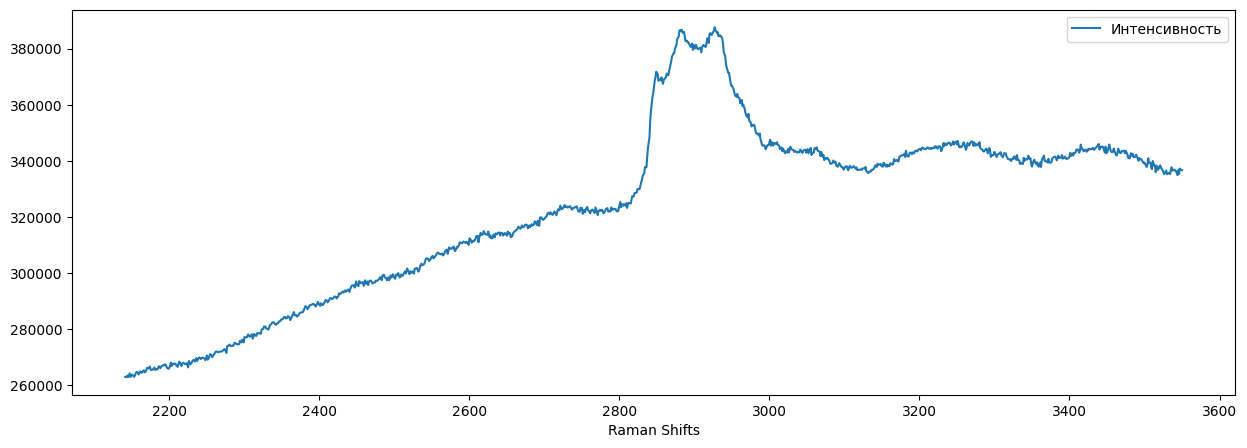

In [ ]:
raman_shifts.plot(x = 'Raman Shifts', y = 'Интенсивность', figsize=(15, 5))

In [ ]:
raman_shifts = pd.read_csv('/content/data_input4/02_sick/image_tumor_patient20022019_633nm_obj20_power100_1sec_сenter2900_step4um_place1_20200929_1_18.txt', sep="\t", header=None)
raman_shifts.drop(columns=[2], inplace = True)
raman_shifts.columns = ["Raman Shifts", "Интенсивность"]
raman_shifts.drop(raman_shifts.head(1).index, inplace=True)
raman_shifts["Raman Shifts"] = pd.to_numeric(raman_shifts["Raman Shifts"], errors='coerce').astype(np.int64)

<Axes: xlabel='Raman Shifts'>

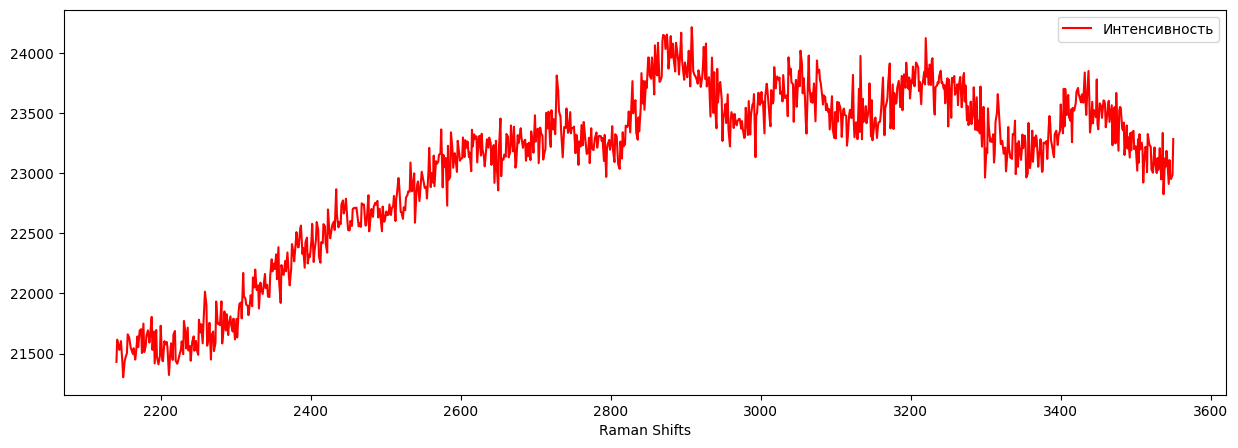

In [ ]:
raman_shifts.plot(x = 'Raman Shifts', y = 'Интенсивность', figsize=(15, 5), color = 'red')

In [ ]:
raman_shifts["Raman Shifts"].value_counts()

3550    1
2641    1
2660    1
2658    1
2657    1
       ..
3111    1
3110    1
3108    1
3107    1
2141    1
Name: Raman Shifts, Length: 1015, dtype: int64

In [ ]:
RS = np.array(raman_shifts["Raman Shifts"])
RS

array([3550, 3549, 3547, ..., 2144, 2142, 2141])

Все в единичном экземпляре, отлично

In [ ]:
df = pd.DataFrame(data = X)
df.columns = RS
df = df[RS[::-1]]
target = pd.DataFrame(data = y)
df['target'] = target[1]
df

,2141,2142,2144,2145,2147,2149,2150,2152,2153,2155,...,3540,3541,3542,3544,3545,3546,3547,3549,3550,target
0,48824.140625,49260.035156,48808.093750,49411.957031,49368.914063,49103.656250,49175.621094,48806.210938,48922.917969,49182.097656,...,46691.699219,46520.566406,47016.984375,46516.023438,46591.121094,46584.777344,46694.542969,46496.671875,46702.472656,1
1,205885.578125,206059.062500,206184.703125,207308.875000,206698.187500,206403.640625,206072.156250,206423.359375,206382.812500,207385.468750,...,242788.796875,243469.500000,242172.093750,242063.015625,243102.296875,241793.703125,243208.156250,242269.812500,241685.031250,1
2,24596.572266,24492.814453,25002.316406,24805.945313,24649.417969,24697.406250,24785.390625,24684.703125,24809.515625,24598.371094,...,27818.179688,28019.484375,27917.597656,27738.300781,27774.771484,27744.041016,27923.121094,27654.007813,27908.705078,1
3,46836.628906,47128.292969,47067.117188,47480.402344,47254.679688,47182.285156,46900.394531,46783.082031,46936.054688,47338.730469,...,47057.925781,46286.539063,46740.164063,46528.238281,46481.160156,46680.503906,46686.394531,46838.992188,46301.058594,1
4,51622.621094,51768.625000,52307.621094,52084.816406,51901.839844,51920.175781,51834.585938,51771.335938,52035.992188,52070.363281,...,48819.875000,48667.511719,48500.832031,48832.867188,48857.550781,48346.574219,48911.011719,48526.152344,48939.789063,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,22666.765625,22525.132813,...,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,30546.441406,30399.732422,1
1018,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,22666.765625,...,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,30546.441406,1
1019,22623.326172,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,...,30257.056641,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,1
1020,22792.033203,22623.326172,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,...,30718.039063,30257.056641,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,1


In [ ]:
health = df[df['target'] == 0]
health = health.drop(['target'], axis=1)

sick = df[df['target'] == 1]
sick = sick.drop(['target'], axis=1)

In [ ]:
H = pd.DataFrame(health.mean())
H['median'] = health.median()
H['percentile_10'] = health.quantile(.10)
H['percentile_90'] = health.quantile(.90)

S = pd.DataFrame(sick.mean())
S['median'] = sick.median()
S['percentile_10'] = sick.quantile(.10)
S['percentile_90'] = sick.quantile(.90)

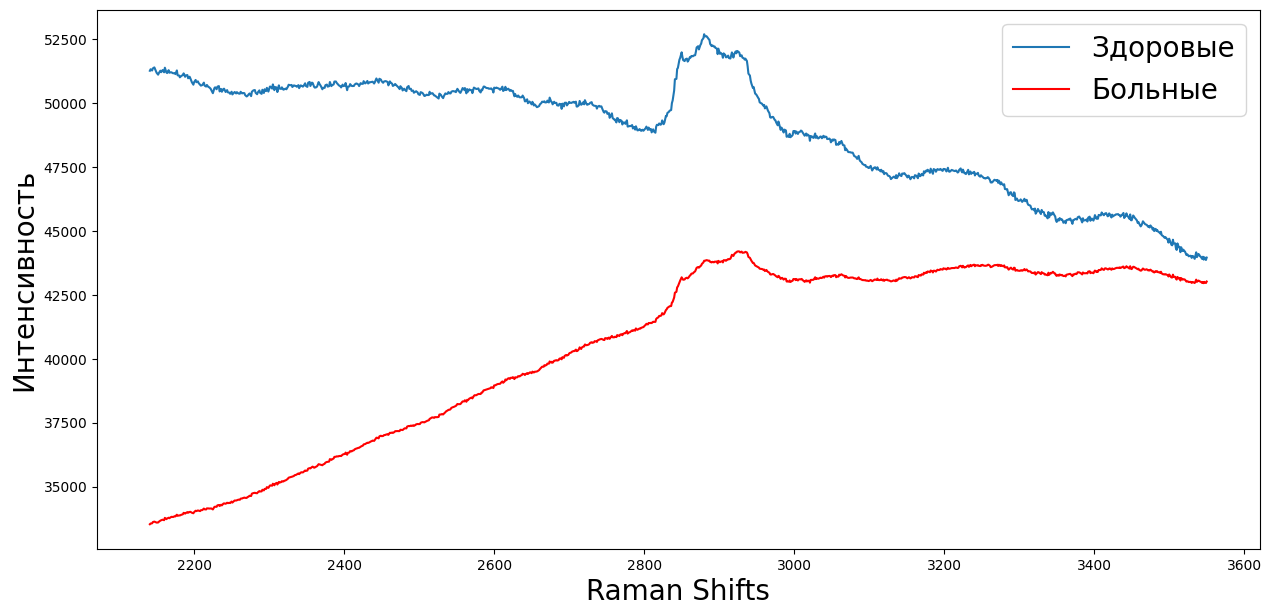

In [ ]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

#plt.title('Сравнение усредненных графиков Рамановской спектроскопии для здоровых и больных тканей')

plt.plot(H.index, H[0], label='Здоровые')
plt.plot(S.index, S[0], label='Больные', color = 'red')

plt.legend(prop={'size': 20})

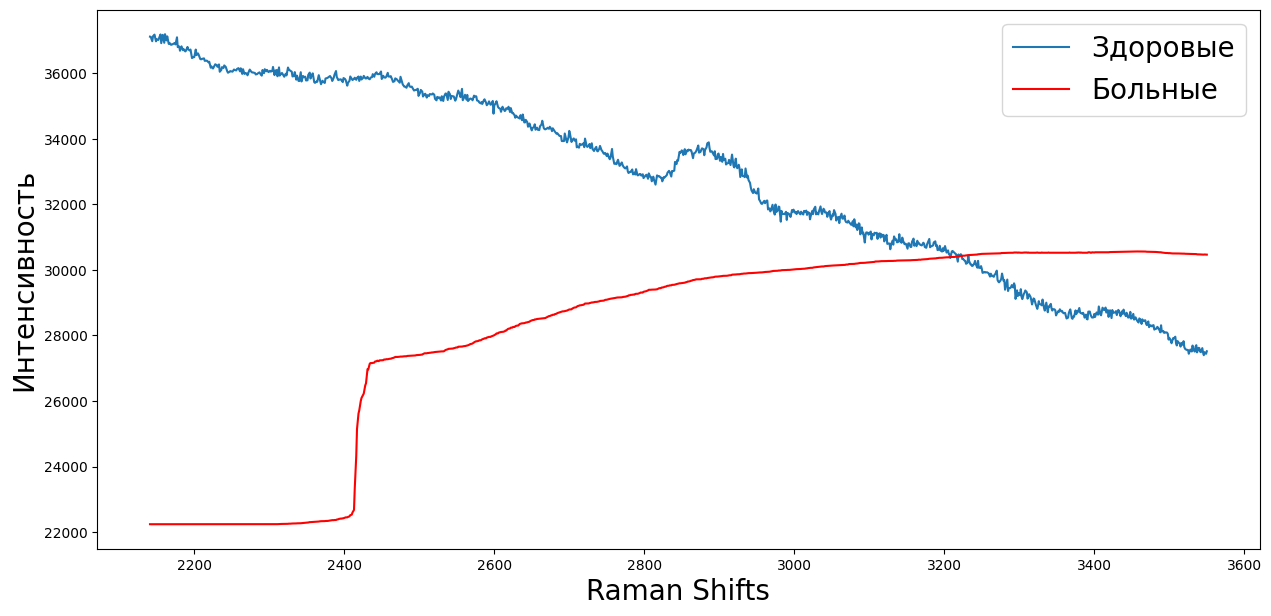

In [ ]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

#plt.title('Сравнение медиан графиков Рамановской спектроскопии для здоровых и больных тканей')

plt.plot(H.index, H['median'], label='Здоровые')
plt.plot(S.index, S['median'], label='Больные', color = 'red')

plt.legend(prop={'size': 20})

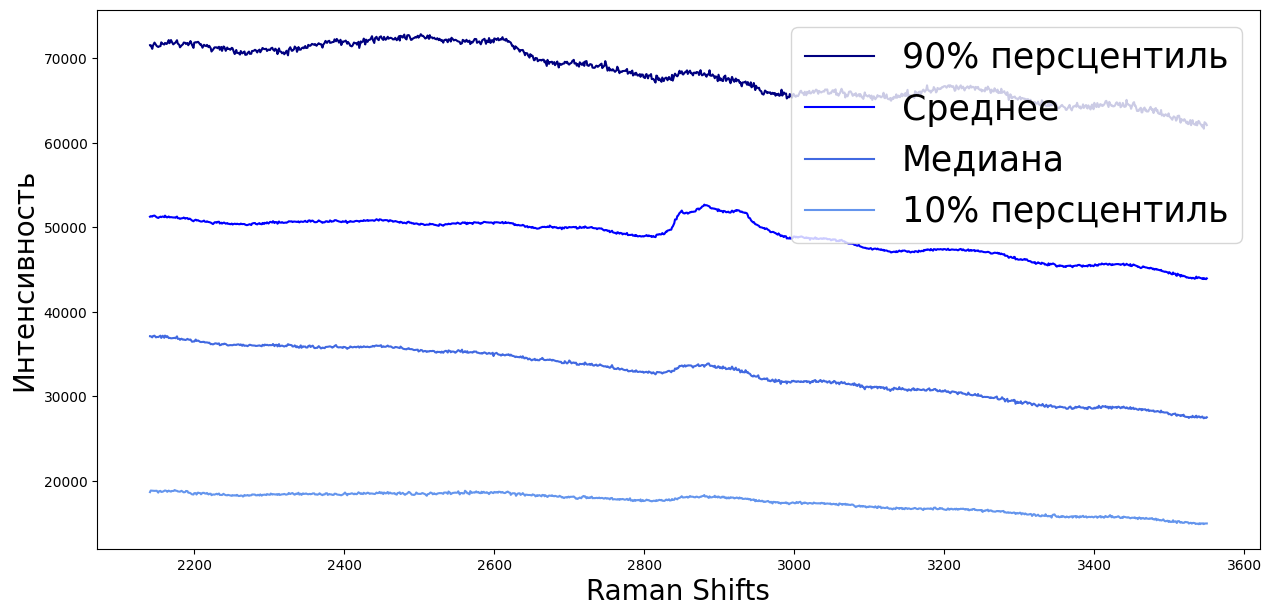

In [ ]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

#plt.title('Здоровые ткани')

plt.plot(H.index, H['percentile_90'], label='90% персцентиль', color = 'navy')
plt.plot(H.index, H[0], label='Среднее', color = 'blue')
plt.plot(H.index, H['median'], label='Медиана', color = 'royalblue')
plt.plot(H.index, H['percentile_10'], label='10% персцентиль', color = 'cornflowerblue')

plt.legend(prop={'size': 25})

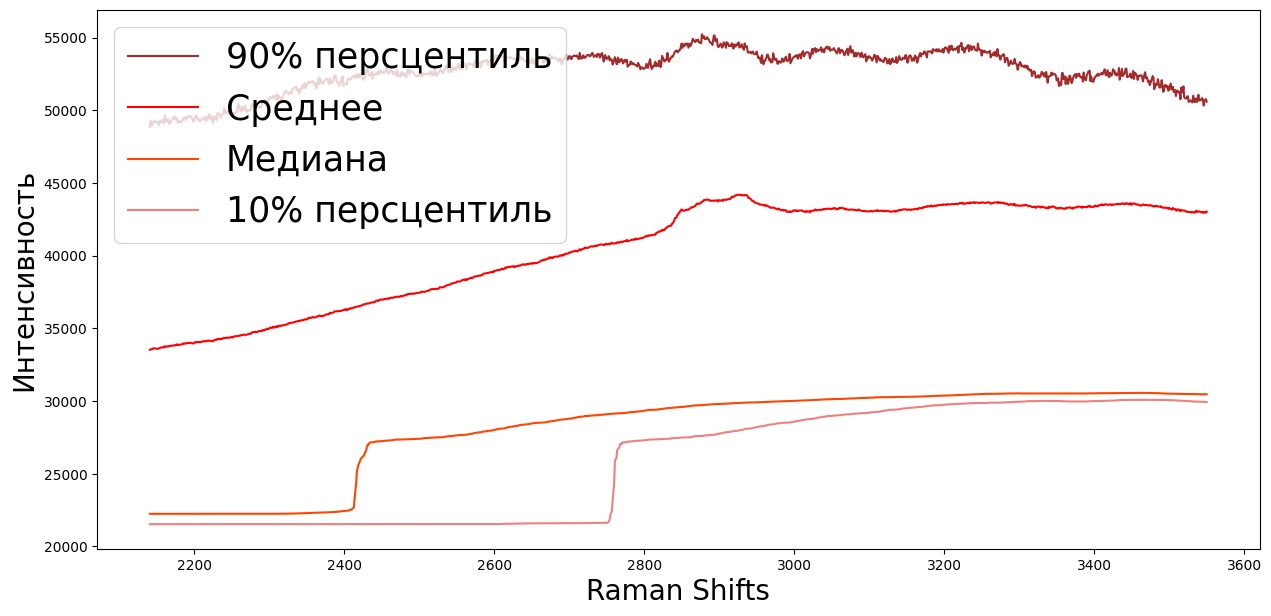

In [ ]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

#plt.title('Больные ткани')

plt.plot(S.index, S['percentile_90'], label='90% персцентиль', color = 'brown')
plt.plot(S.index, S[0], label='Среднее', color = 'red')
plt.plot(S.index, S['median'], label='Медиана', color = 'orangered')
plt.plot(S.index, S['percentile_10'], label='10% персцентиль', color = 'lightcoral')

plt.legend(prop={'size': 25})

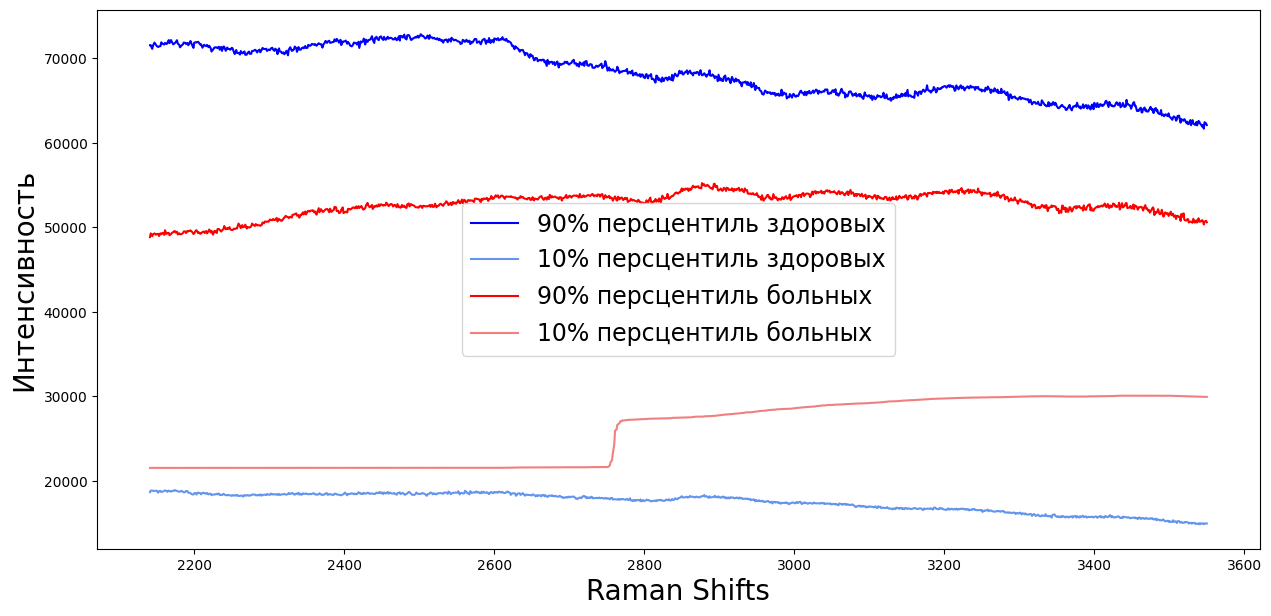

In [ ]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

#plt.title('Здоровые ткани')

plt.plot(H.index, H['percentile_90'], label='90% персцентиль здоровых', color = 'blue')
#plt.plot(H.index, H[0], label='Среднее')
#plt.plot(H.index, H['median'], label='Медиана')
plt.plot(H.index, H['percentile_10'], label='10% персцентиль здоровых', color = 'cornflowerblue')

plt.plot(S.index, S['percentile_90'], label='90% персцентиль больных', color = 'red')
#plt.plot(S.index, S[0], label='Среднее')
#plt.plot(S.index, S['median'], label='Медиана')
plt.plot(S.index, S['percentile_10'], label='10% персцентиль больных', color = 'lightcoral')

plt.legend(prop={'size': 17})

In [ ]:
df['target'].value_counts()

1    590
0    432
Name: target, dtype: int64

# 3. Classic ML

In [ ]:
X = df.drop(['target'], axis=1)
y = df['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')

Total amount of train measurements: (817, 1015)
Total amount of train labels: (817,)
Total amount of test measurements: (205, 1015)
Total amount of test labels: (205,)


## 3.1 Logistic regression

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
LogReg = LogisticRegression(solver='lbfgs', max_iter=100000)
LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [ ]:
y_pred_lr = LogReg.predict(X_test)

print(f'Logistic Regression F1 Score {f1_score(y_test, y_pred_lr)}')
print(f'Logistic Regression Accuracy {accuracy_score(y_test, y_pred_lr)}')

Logistic Regression F1 Score 0.9067796610169493
Logistic Regression Accuracy 0.8926829268292683


In [ ]:
y_test.value_counts()

1    124
0     81
Name: target, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix 

cm_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr))
cm_lr

,0,1
0,76,5
1,17,107


In [ ]:
sensitivity = cm_lr[0][0] / (cm_lr[0][0] + cm_lr[1][0])
specificity = cm_lr[1][1] / (cm_lr[0][1] + cm_lr[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9382716049382716
Доля верно обнаруженных больных :  0.8629032258064516


In [ ]:
LR_metric = [accuracy_score(y_test, y_pred_lr), f1_score(y_test, y_pred_lr), specificity, sensitivity]
LR_metric

[0.8926829268292683,
 0.9067796610169493,
 0.8629032258064516,
 0.9382716049382716]

## 3.2 Support vector machine (SVM)

In [ ]:
from sklearn.svm import SVC

SVM_rbf = SVC(kernel='rbf')
SVM_rbf.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_svm_rbf = SVM_rbf.predict(X_test)

print(f'Rbf SVM F1 Score {f1_score(y_test, y_pred_svm_rbf)}')
print(f'Rbf SVM Accuracy {accuracy_score(y_test, y_pred_svm_rbf)}')

Rbf SVM F1 Score 0.8796992481203008
Rbf SVM Accuracy 0.8439024390243902


Попробуем линейный SVM

In [ ]:
SVM_lnr = SVC(kernel='linear')
SVM_lnr.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred_svm_lnr = SVM_lnr.predict(X_test)

print(f'Linear SVM F1 Score {f1_score(y_test, y_pred_svm_lnr)}')
print(f'Linear SVM Accuracy {accuracy_score(y_test, y_pred_svm_lnr)}')

Linear SVM F1 Score 0.9128630705394192
Linear SVM Accuracy 0.8975609756097561


In [ ]:
cm_svm_lnr = pd.DataFrame(confusion_matrix(y_test, y_pred_svm_lnr))
cm_svm_lnr

,0,1
0,74,7
1,14,110


In [ ]:
sensitivity = cm_svm_lnr[0][0] / (cm_svm_lnr[0][0] + cm_svm_lnr[1][0])
specificity = cm_svm_lnr[1][1] / (cm_svm_lnr[0][1] + cm_svm_lnr[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9135802469135802
Доля верно обнаруженных больных :  0.8870967741935484


In [ ]:
SVM_metric = [accuracy_score(y_test, y_pred_svm_lnr), f1_score(y_test, y_pred_svm_lnr), specificity, sensitivity]
SVM_metric

[0.8975609756097561,
 0.9128630705394192,
 0.8870967741935484,
 0.9135802469135802]

## 3.3 Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rf = RF.predict(X_test)

print(f'Random forest F1 Score {f1_score(y_test, y_pred_rf)}')
print(f'Random forest Accuracy {accuracy_score(y_test, y_pred_rf)}')

Random forest F1 Score 0.9382716049382716
Random forest Accuracy 0.926829268292683


In [ ]:
cm_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf))
cm_rf

,0,1
0,76,5
1,10,114


In [ ]:
sensitivity = cm_rf[0][0] / (cm_rf[0][0] + cm_rf[1][0])
specificity = cm_rf[1][1] / (cm_rf[0][1] + cm_rf[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9382716049382716
Доля верно обнаруженных больных :  0.9193548387096774


In [ ]:
RF_metric = [accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf), specificity, sensitivity]
RF_metric

[0.926829268292683, 0.9382716049382716, 0.9193548387096774, 0.9382716049382716]

## 3.4 Catboost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

CatBoost = CatBoostClassifier(verbose=False)
CatBoost.fit(X_train, y_train)

In [ ]:
y_pred_cb = CatBoost.predict(X_test)

print(f'CatBoost F1 Score {f1_score(y_test, y_pred_cb)}')
print(f'CatBoost Accuracy {accuracy_score(y_test, y_pred_cb)}')

CatBoost F1 Score 0.9382716049382716
CatBoost Accuracy 0.926829268292683


In [ ]:
cm_cb = pd.DataFrame(confusion_matrix(y_test, y_pred_cb))
cm_cb

,0,1
0,76,5
1,10,114


In [ ]:
sensitivity = cm_cb[0][0] / (cm_cb[0][0] + cm_cb[1][0])
specificity = cm_cb[1][1] / (cm_cb[0][1] + cm_cb[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9382716049382716
Доля верно обнаруженных больных :  0.9193548387096774


In [ ]:
CB_metric = [accuracy_score(y_test, y_pred_cb), f1_score(y_test, y_pred_cb), specificity, sensitivity]
CB_metric

[0.926829268292683, 0.9382716049382716, 0.9193548387096774, 0.9382716049382716]

## 3.5 Ансамбль моделей

Дадим CatBoost и RF вес 2, как лучшим моделям

In [ ]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 0.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,4,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,6,1
717,1,6,1
925,1,6,1
559,1,6,1


In [ ]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9224806201550387
Ensemble Accuracy 0.9024390243902439


In [ ]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,66,15
1,5,119


In [ ]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.8148148148148148
Доля верно обнаруженных больных :  0.9596774193548387


In [ ]:
ENS_1_metric = [acc, f1, specificity, sensitivity]
ENS_1_metric

[0.9024390243902439,
 0.9224806201550387,
 0.9596774193548387,
 0.8148148148148148]

выберем порог < 1.5

In [ ]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 1.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,4,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,6,1
717,1,6,1
925,1,6,1
559,1,6,1


In [ ]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9402390438247011
Ensemble Accuracy 0.926829268292683


In [ ]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,72,9
1,6,118


In [ ]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.8888888888888888
Доля верно обнаруженных больных :  0.9516129032258065


In [ ]:
ENS_2_metric = [acc, f1, specificity, sensitivity]
ENS_2_metric

[0.926829268292683, 0.9402390438247011, 0.9516129032258065, 0.8888888888888888]

выберем порог < 2.5

In [ ]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 2.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,4,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,6,1
717,1,6,1
925,1,6,1
559,1,6,1


In [ ]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9421487603305785
Ensemble Accuracy 0.9317073170731708


In [ ]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,77,4
1,10,114


In [ ]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9506172839506173
Доля верно обнаруженных больных :  0.9193548387096774


In [ ]:
ENS_3_metric = [acc, f1, specificity, sensitivity]
ENS_3_metric

[0.9317073170731708,
 0.9421487603305785,
 0.9193548387096774,
 0.9506172839506173]

Выберем порог < 3.5

In [ ]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 3.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,4,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,6,1
717,1,6,1
925,1,6,1
559,1,6,1


In [ ]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9421487603305785
Ensemble Accuracy 0.9317073170731708


In [ ]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,77,4
1,10,114


In [ ]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9506172839506173
Доля верно обнаруженных больных :  0.9193548387096774


In [ ]:
ENS_4_metric = [acc, f1, specificity, sensitivity]
ENS_4_metric

[0.9317073170731708,
 0.9421487603305785,
 0.9193548387096774,
 0.9506172839506173]

выберем порог < 4.5

In [ ]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 4.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,4,0
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,6,1
717,1,6,1
925,1,6,1
559,1,6,1


In [ ]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9217391304347826
Ensemble Accuracy 0.9121951219512195


In [ ]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,81,0
1,18,106


In [ ]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  1.0
Доля верно обнаруженных больных :  0.8548387096774194


In [ ]:
ENS_5_metric = [acc, f1, specificity, sensitivity]
ENS_5_metric

[0.9121951219512195, 0.9217391304347826, 0.8548387096774194, 1.0]

## 3.6 Результаты

In [ ]:
res = pd.DataFrame()

res['LR'] = LR_metric
res['SVM'] = SVM_metric
res['RF'] = RF_metric
res['CB'] = CB_metric
res['ENS_1'] = ENS_1_metric
res['ENS_2'] = ENS_2_metric
res['ENS_3'] = ENS_3_metric
res['ENS_4'] = ENS_4_metric
res['ENS_5'] = ENS_5_metric

res.index = ['Точность', 'F1 мера', 'Доля верно обнаруженных больных', 'Доля верно обнаруженных здоровых']
res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000


# 4. Кластеризация без учителя

## 4.1. TSNE

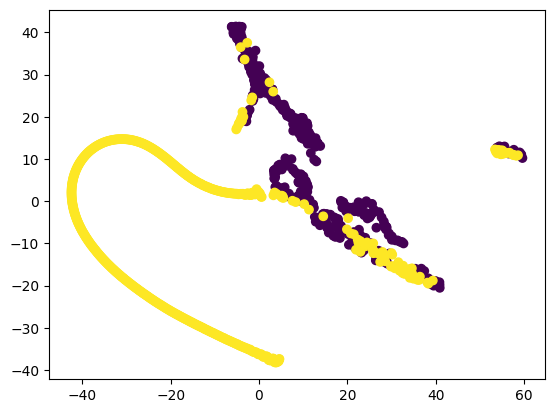

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model = TSNE(learning_rate=100)

transformed = model.fit_transform(X)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis, c=y)
plt.show()

## 4.2. K-means

In [ ]:
from sklearn.cluster import KMeans

acc_sc = pd.Series()
f1_scr = pd.Series()
sensit = pd.Series()
specif = pd.Series()

iter = 50

for i in range (2, iter):
  model = KMeans(n_clusters=i)
  model.fit(X)

  all_predictions = model.predict(X)
  A = pd.DataFrame(all_predictions)
  A[1] = y

  K1 = A[A[1] == 1]
  s1 = set(K1[0])

  K0 = A[A[1] == 0]
  s0 = set(K0[0])

  A['pred'] = A[0].apply(lambda x: 0 if ((x in s1) == False) else
                                   1 if ((x in s0) == False) else
                                   0 if (A.groupby([1, 0]).value_counts()[0, x] > A.groupby([1, 0]).value_counts()[1, x]) else 1)
  
  acc = accuracy_score(A[1], A['pred'])
  f1 = f1_score(A[1], A['pred'])

  cm = pd.DataFrame(confusion_matrix(A[1], A['pred']))
  sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
  specificity = cm[1][1] / (cm[0][1] + cm[1][1])

  acc_sc[str(i)] = round(acc, 3)
  f1_scr[str(i)] = round(f1, 3)
  sensit[str(i)] = round(sensitivity, 3)
  specif[str(i)] = round(specificity, 3)

In [ ]:
Res = pd.DataFrame()
Res['Точность'] = acc_sc
Res['F1 мера'] = f1_scr
Res['Доля верно обнаруженных здоровых'] = sensit
Res['Доля верно обнаруженных больных'] = specif

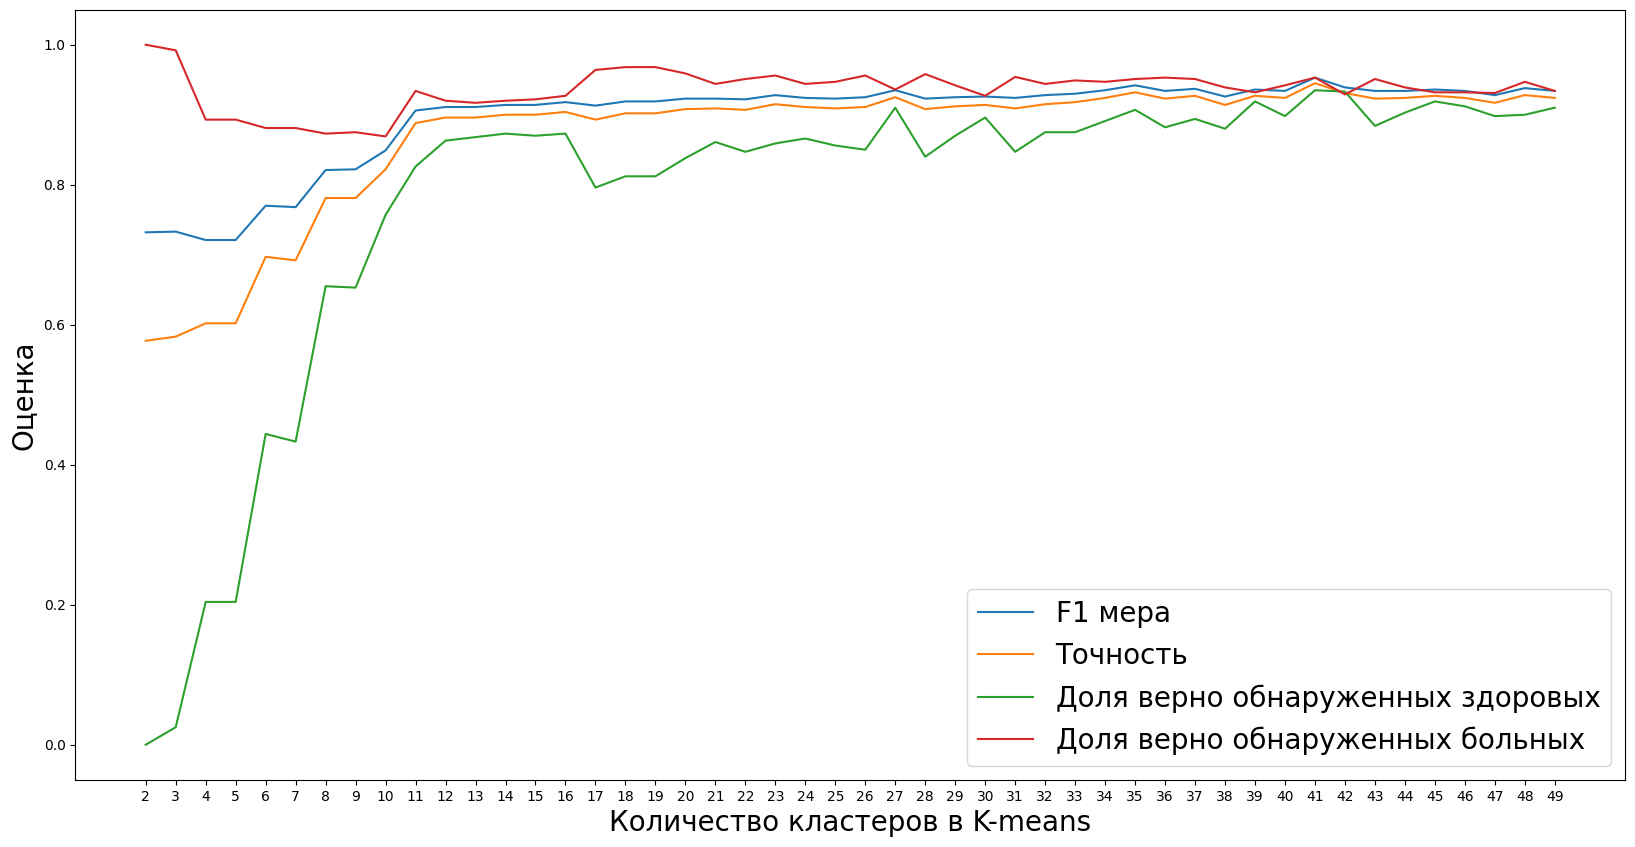

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка", fontsize=20)
plt.xlabel("Количество кластеров в K-means", fontsize=20)

#plt.title('Оценка метрик в зависимости от количества кластеров в K-means')

plt.plot(Res.index, Res['F1 мера'], label='F1 мера')
plt.plot(Res.index, Res['Точность'], label='Точность')
plt.plot(Res.index, Res['Доля верно обнаруженных здоровых'], label='Доля верно обнаруженных здоровых')
plt.plot(Res.index, Res['Доля верно обнаруженных больных'], label='Доля верно обнаруженных больных')

plt.legend(prop={'size': 20})

In [ ]:
Res.sort_values(by='F1 мера', ascending=False)

,Точность,F1 мера,Доля верно обнаруженных здоровых,Доля верно обнаруженных больных
42,0.939,0.948,0.926,0.949
49,0.938,0.946,0.940,0.937
45,0.930,0.940,0.900,0.951
39,0.932,0.940,0.935,0.929
47,0.927,0.938,0.882,0.959
37,0.928,0.938,0.896,0.951
38,0.926,0.937,0.891,0.951
36,0.927,0.937,0.898,0.947
46,0.925,0.936,0.884,0.954
33,0.924,0.935,0.891,0.947


In [ ]:
from sklearn.cluster import KMeans

acc_sc = pd.Series()
f1_scr = pd.Series()
sensit = pd.Series()
specif = pd.Series()

iter = 50

for i in range (15, iter):

  acc = 0
  f1 = 0
  sensitivity = 0
  specificity = 0

  for j in range (10):
    model = KMeans(n_clusters=i)
    model.fit(X)

    all_predictions = model.predict(X)
    A = pd.DataFrame(all_predictions)
    A[1] = y

    K1 = A[A[1] == 1]
    s1 = set(K1[0])

    K0 = A[A[1] == 0]
    s0 = set(K0[0])

    A['pred'] = A[0].apply(lambda x: 0 if ((x in s1) == False) else
                                     1 if ((x in s0) == False) else
                                     0 if (A.groupby([1, 0]).value_counts()[0, x] > A.groupby([1, 0]).value_counts()[1, x]) else 1)
  
    acc += accuracy_score(A[1], A['pred'])
    f1 += f1_score(A[1], A['pred'])

    cm = pd.DataFrame(confusion_matrix(A[1], A['pred']))
    sensitivity += cm[0][0] / (cm[0][0] + cm[1][0])
    specificity += cm[1][1] / (cm[0][1] + cm[1][1])

  acc_sc[str(i)] = round(acc / 10, 3)
  f1_scr[str(i)] = round(f1 / 10, 3)
  sensit[str(i)] = round(sensitivity / 10, 3)
  specif[str(i)] = round(specificity / 10, 3)

In [ ]:
Res = pd.DataFrame()
Res['Точность'] = acc_sc
Res['F1 мера'] = f1_scr
Res['Доля верно обнаруженных здоровых'] = sensit
Res['Доля верно обнаруженных больных'] = specif

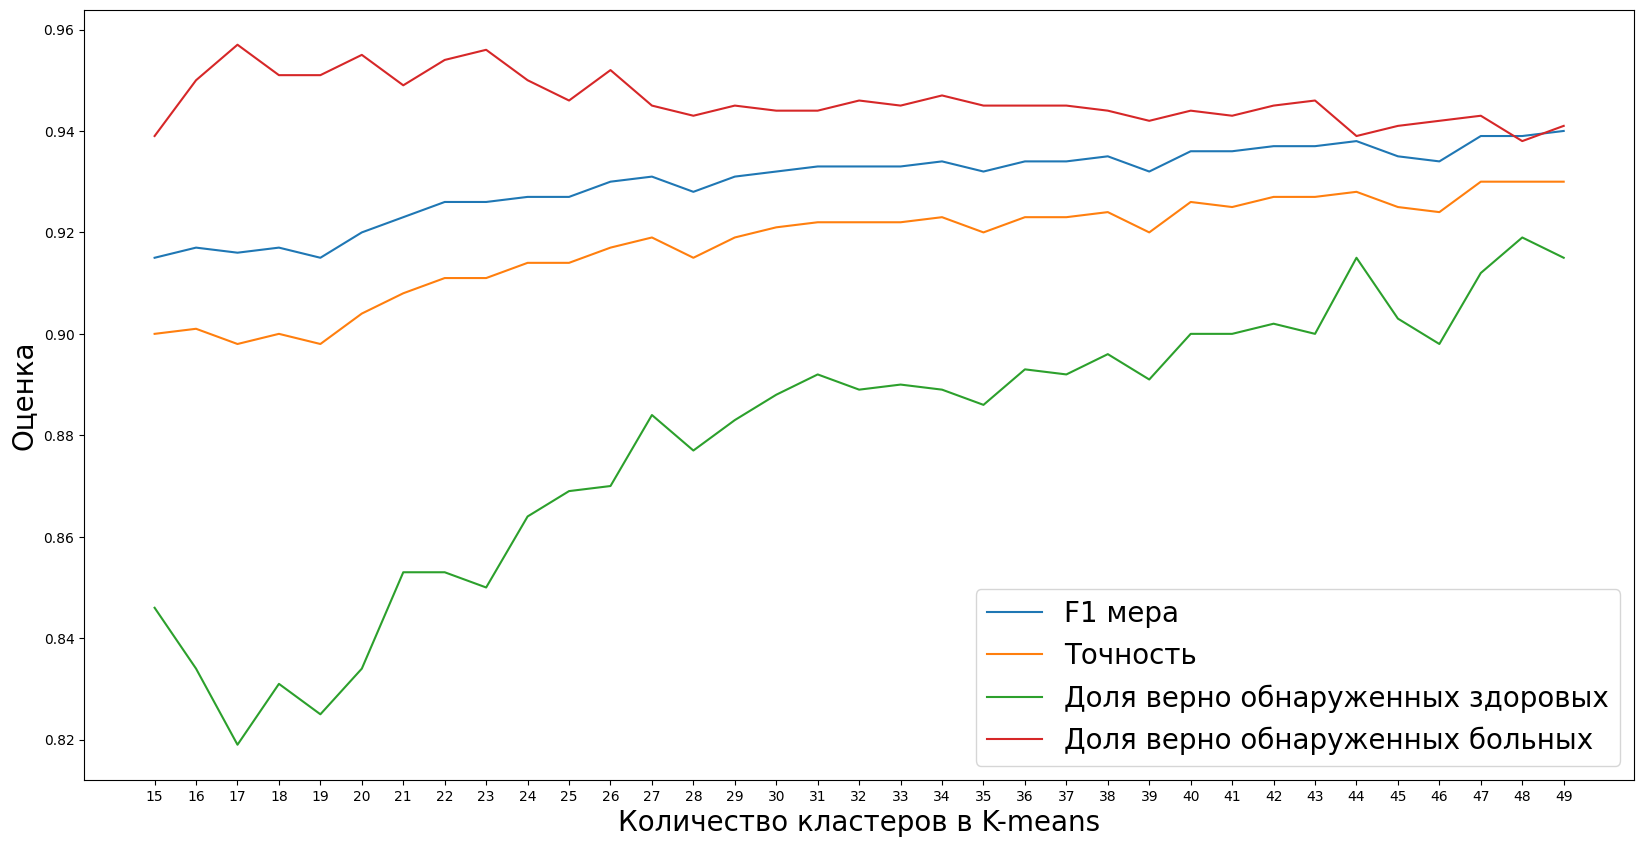

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка", fontsize=20)
plt.xlabel("Количество кластеров в K-means", fontsize=20)

#plt.title('Оценка метрик в зависимости от количества кластеров в K-means')

plt.plot(Res.index, Res['F1 мера'], label='F1 мера')
plt.plot(Res.index, Res['Точность'], label='Точность')
plt.plot(Res.index, Res['Доля верно обнаруженных здоровых'], label='Доля верно обнаруженных здоровых')
plt.plot(Res.index, Res['Доля верно обнаруженных больных'], label='Доля верно обнаруженных больных')

plt.legend(prop={'size': 20})

In [ ]:
Res.sort_values(by='F1 мера', ascending=False).head(20)

,Точность,F1 мера,Доля верно обнаруженных здоровых,Доля верно обнаруженных больных
49,0.930,0.940,0.915,0.941
48,0.930,0.939,0.919,0.938
47,0.930,0.939,0.912,0.943
44,0.928,0.938,0.915,0.939
43,0.927,0.937,0.900,0.946
42,0.927,0.937,0.902,0.945
41,0.925,0.936,0.900,0.943
40,0.926,0.936,0.900,0.944
45,0.925,0.935,0.903,0.941
38,0.924,0.935,0.896,0.944


Выводы

In [ ]:
Best_3 = Res.sort_values(by='F1 мера', ascending=False).head(3)
Best_3 = Best_3.T
Best_3

,49,48,47
Точность,0.930,0.930,0.930
F1 мера,0.940,0.939,0.939
Доля верно обнаруженных здоровых,0.915,0.919,0.912
Доля верно обнаруженных больных,0.941,0.938,0.943


In [ ]:
Best_3.columns = ['K_means_1', 'K_means_2', 'K_means_3']
res['K_means_1'] = Best_3['K_means_1']
res['K_means_2'] = Best_3['K_means_2']
res['K_means_3'] = Best_3['K_means_3']

res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912


In [ ]:
res.drop(columns= ['LR', 'SVM', 'ENS_1', 'ENS_2', 'ENS_5'])

,RF,CB,ENS_3,ENS_4,K_means_1,K_means_2,K_means_3
Точность,0.927,0.927,0.932,0.932,0.930,0.930,0.930
F1 мера,0.938,0.938,0.942,0.942,0.940,0.939,0.939
Доля верно обнаруженных больных,0.919,0.919,0.919,0.919,0.941,0.938,0.943
Доля верно обнаруженных здоровых,0.938,0.938,0.951,0.951,0.915,0.919,0.912


In [ ]:
compression_opts = dict(method='zip', archive_name='result.csv')  
#res.to_csv('ML_result.zip', index=False, compression=compression_opts)  

In [ ]:
res_t = res.T
res_t

,Точность,F1 мера,Доля верно обнаруженных больных,Доля верно обнаруженных здоровых
LR,0.893,0.907,0.863,0.938
SVM,0.898,0.913,0.887,0.914
RF,0.927,0.938,0.919,0.938
CB,0.927,0.938,0.919,0.938
ENS_1,0.902,0.922,0.960,0.815
ENS_2,0.927,0.940,0.952,0.889
ENS_3,0.932,0.942,0.919,0.951
ENS_4,0.932,0.942,0.919,0.951
ENS_5,0.912,0.922,0.855,1.000
K_means_1,0.930,0.940,0.941,0.915


In [ ]:
#res_t.to_csv('ML_result2.zip', index=False, compression=compression_opts) 

# 5. Отбор признаков

## 5.1. Взаимная информация

Отберем 20 самых информативных Raman Shift

<Axes: xlabel='Raman Shift'>

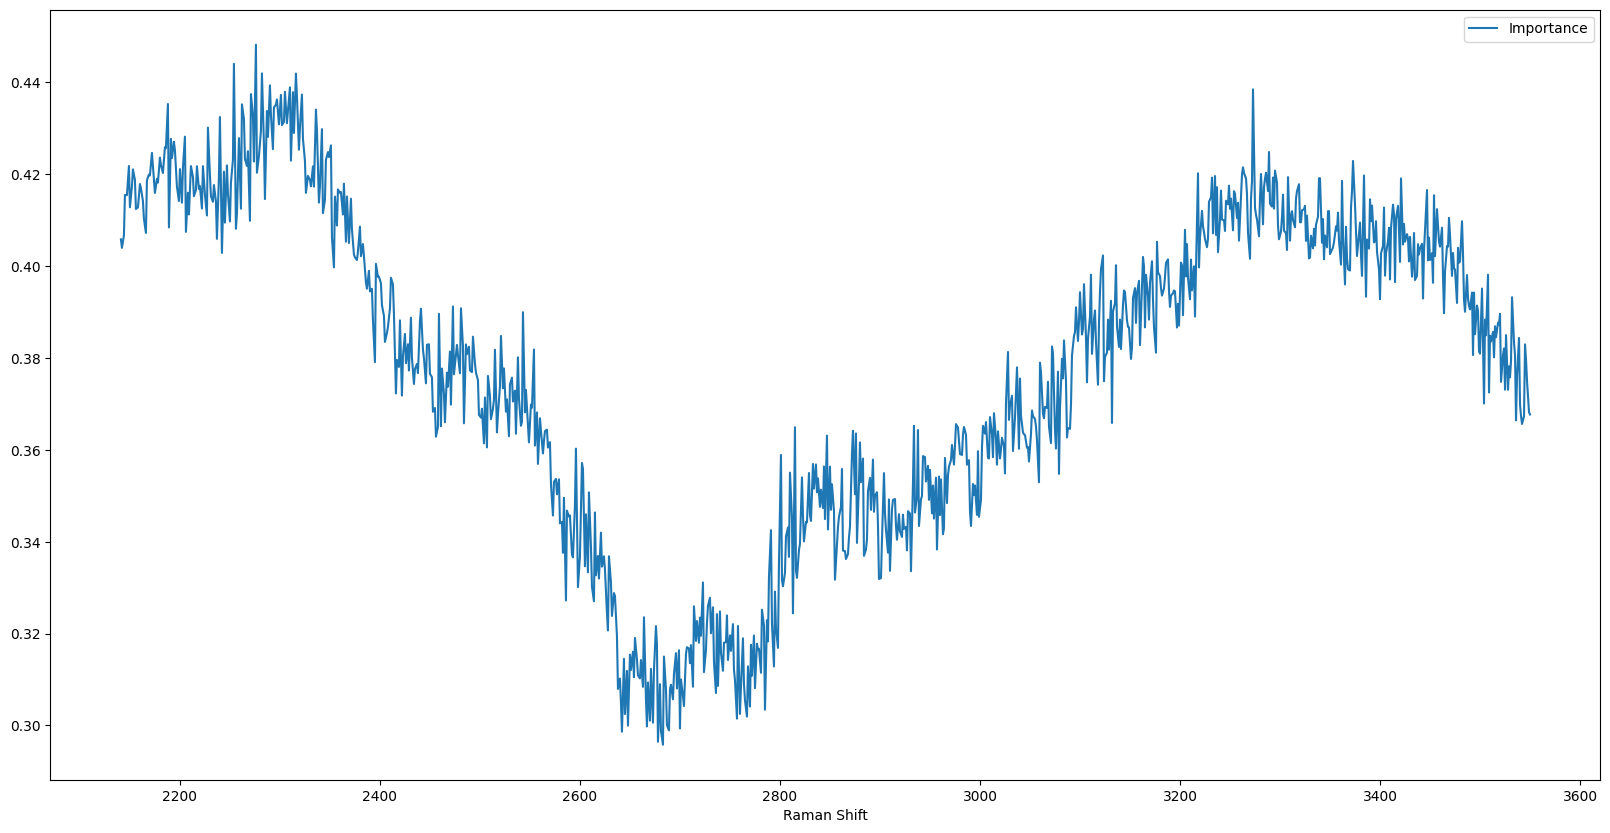

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

importances = mutual_info_classif(X, y)
# Где data - ваш датасет; X, y – входные и выходные данные соответственно
feature_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
feature_importances = pd.DataFrame(feature_importances)
feature_importances.columns = ['Importance']
feature_importances['Raman Shift'] = feature_importances.index
feature_importances.plot(x = 'Raman Shift', y = 'Importance', figsize=(20, 10))

In [ ]:
feature_importances = pd.DataFrame(feature_importances)
feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)
feature_importances.reset_index(inplace = True)
feature_importances.drop('index', axis=1, inplace = True)
feature_importances

,Importance,Raman Shift
0,0.448217,2276
1,0.444072,2254
2,0.441974,2282
3,0.441940,2316
4,0.439378,2290
...,...,...
1010,0.298925,2689
1011,0.298828,2681
1012,0.298634,2642
1013,0.296452,2678


Напишем функцию для отбора n лучших признаков

In [ ]:
def df_best_n_features(n):

  n_features = feature_importances.head(n)
  best_n_ftr_list = list(n_features['Raman Shift'])

  df_t = df.T
  df_best_n_features = df_t.loc[best_n_ftr_list]
  df_best_n_features = df_best_n_features.T
  df_best_n_features['target'] = df.target

  return(df_best_n_features)

Оставим лучшие 50 признаков

In [ ]:
df_best_50_features = df_best_n_features(50)
df_best_50_features

,2276,2254,2282,2316,2290,2310,3273,2305,2313,2271,...,2284,2351,2185,2186,2293,2319,2195,2268,3289,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14562.829102,14713.603516,14228.577148,14731.752930,14783.629883,14442.664063,...,14722.721680,14834.486328,14552.708008,14461.596680,14714.454102,14553.829102,14624.338867,14441.714844,13879.888672,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15562.816406,15772.785156,15149.055664,15681.818359,15838.429688,15553.763672,...,15625.213867,15791.922852,15647.779297,15844.866211,15624.896484,15920.563477,15745.570313,15517.995117,15149.485352,0
2,20234.121094,20282.953125,20402.167969,20457.568359,20322.167969,20513.652344,19699.015625,20707.810547,20673.751953,20138.478516,...,20124.595703,20592.335938,20327.158203,20313.146484,20432.556641,20344.769531,20265.937500,20320.484375,19894.896484,0
3,44321.910156,44553.687500,44583.531250,44758.605469,44647.730469,44725.585938,45610.453125,44983.050781,44840.671875,43920.421875,...,44380.878906,45034.437500,44624.726563,44872.781250,44575.828125,44854.058594,44519.183594,44479.871094,45625.820313,0
4,43332.187500,44180.933594,43104.050781,42258.046875,42727.699219,42505.140625,23579.816406,42628.136719,42436.707031,43448.683594,...,43026.906250,41520.210938,46623.441406,46738.519531,42699.019531,42414.714844,45906.125000,43442.511719,23492.244141,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,22215.191406,22015.281250,22600.001953,...,22633.355469,22207.082031,22443.265625,22356.267578,22333.017578,22188.679688,22545.599609,22372.314453,29713.128906,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,22454.488281,22305.763672,22568.464844,...,22770.496094,22228.414063,22692.705078,22443.265625,22258.292969,22373.847656,22460.685547,22655.052734,29738.818359,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,22306.289063,22260.986328,22372.314453,...,22337.785156,22030.060547,22476.832031,22692.705078,22309.355469,22315.832031,22464.564453,22558.070313,29773.201172,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,22126.199219,22210.582031,22655.052734,...,22431.828125,22091.179688,22377.328125,22476.832031,22549.919922,22474.501953,22470.287109,22616.294922,29713.501953,1


In [ ]:
from sklearn.model_selection import train_test_split

X_50 = df_best_50_features.drop(['target'], axis=1)
y_50 = df_best_50_features['target']

X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_50, y_50, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train_50, y_train_50)

y_pred_rf_50 = RF.predict(X_test_50)

print(f'Random forest F1 Score на 50 признаках {f1_score(y_test_50, y_pred_rf_50)}')
print(f'Random forest Accuracy на 50 признаках {accuracy_score(y_test_50, y_pred_rf_50)}')

Random forest F1 Score на 50 признаках 0.951219512195122
Random forest Accuracy на 50 признаках 0.9414634146341463


Оставим лучшие 20 признаков

In [ ]:
df_best_20_features = df_best_n_features(20)
df_best_20_features

,2276,2254,2282,2316,2290,2310,3273,2305,2313,2271,...,2301,2317,2297,2188,2262,2296,2294,2336,2308,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14562.829102,14713.603516,14228.577148,14731.752930,14783.629883,14442.664063,...,14769.537109,14790.139648,14616.062500,14486.275391,14534.288086,14862.954102,14634.721680,14842.541016,14722.941406,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15562.816406,15772.785156,15149.055664,15681.818359,15838.429688,15553.763672,...,15804.125977,15786.562500,15705.835938,15606.049805,15609.454102,15662.459961,15728.845703,16016.880859,15808.118164,0
2,20234.121094,20282.953125,20402.167969,20457.568359,20322.167969,20513.652344,19699.015625,20707.810547,20673.751953,20138.478516,...,20637.673828,20778.542969,20479.531250,20328.085938,20156.101563,20407.072266,20323.181641,20773.619141,20537.912109,0
3,44321.910156,44553.687500,44583.531250,44758.605469,44647.730469,44725.585938,45610.453125,44983.050781,44840.671875,43920.421875,...,44653.101563,44855.648438,44756.230469,44401.796875,44095.003906,44417.007813,44760.964844,45172.691406,44687.777344,0
4,43332.187500,44180.933594,43104.050781,42258.046875,42727.699219,42505.140625,23579.816406,42628.136719,42436.707031,43448.683594,...,42880.441406,42397.203125,42895.996094,46601.050781,43524.628906,42763.679688,43207.992188,41547.101563,42581.191406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,22215.191406,22015.281250,22600.001953,...,22126.199219,22373.847656,22523.562500,22324.660156,22667.013672,22377.355469,22364.574219,22181.687500,22210.582031,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,22454.488281,22305.763672,22568.464844,...,22551.419922,22315.832031,22377.355469,22356.267578,22682.205078,22364.574219,22333.017578,22337.126953,22188.423828,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,22306.289063,22260.986328,22372.314453,...,22523.562500,22474.501953,22364.574219,22443.265625,22564.750000,22333.017578,22258.292969,22095.730469,22215.191406,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,22126.199219,22210.582031,22655.052734,...,22377.355469,22015.281250,22333.017578,22692.705078,22385.714844,22258.292969,22309.355469,22273.779297,22454.488281,1


In [ ]:
from sklearn.model_selection import train_test_split

X_20 = df_best_20_features.drop(['target'], axis=1)
y_20 = df_best_20_features['target']

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.2, random_state=42)

In [ ]:
RF.fit(X_train_20, y_train_20)

y_pred_rf_20 = RF.predict(X_test_20)

print(f'Random forest F1 Score на 20 признаках {f1_score(y_test_20, y_pred_rf_20)}')
print(f'Random forest Accuracy на 20 признаках {accuracy_score(y_test_20, y_pred_rf_20)}')

Random forest F1 Score на 20 признаках 0.9344262295081968
Random forest Accuracy на 20 признаках 0.9219512195121952


Оставим лучшие 10 признаков

In [ ]:
df_best_10_features = df_best_n_features(10)
df_best_10_features

,2276,2254,2282,2316,2290,2310,3273,2305,2313,2271,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14562.829102,14713.603516,14228.577148,14731.752930,14783.629883,14442.664063,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15562.816406,15772.785156,15149.055664,15681.818359,15838.429688,15553.763672,0
2,20234.121094,20282.953125,20402.167969,20457.568359,20322.167969,20513.652344,19699.015625,20707.810547,20673.751953,20138.478516,0
3,44321.910156,44553.687500,44583.531250,44758.605469,44647.730469,44725.585938,45610.453125,44983.050781,44840.671875,43920.421875,0
4,43332.187500,44180.933594,43104.050781,42258.046875,42727.699219,42505.140625,23579.816406,42628.136719,42436.707031,43448.683594,0
...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,22215.191406,22015.281250,22600.001953,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,22454.488281,22305.763672,22568.464844,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,22306.289063,22260.986328,22372.314453,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,22126.199219,22210.582031,22655.052734,1


In [ ]:
from sklearn.model_selection import train_test_split

X_10 = df_best_10_features.drop(['target'], axis=1)
y_10 = df_best_10_features['target']

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

In [ ]:
RF.fit(X_train_10, y_train_10)

y_pred_rf_10 = RF.predict(X_test_10)

print(f'Random forest F1 Score на 10 признаках {f1_score(y_test_10, y_pred_rf_10)}')
print(f'Random forest Accuracy на 10 признаках {accuracy_score(y_test_10, y_pred_rf_10)}')

Random forest F1 Score на 10 признаках 0.9349593495934959
Random forest Accuracy на 10 признаках 0.9219512195121952


Оставим лучшие 5 признаков

In [ ]:
df_best_5_features = df_best_n_features(5)
df_best_5_features

,2276,2254,2282,2316,2290,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14562.829102,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15562.816406,0
2,20234.121094,20282.953125,20402.167969,20457.568359,20322.167969,0
3,44321.910156,44553.687500,44583.531250,44758.605469,44647.730469,0
4,43332.187500,44180.933594,43104.050781,42258.046875,42727.699219,0
...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,1


In [ ]:
from sklearn.model_selection import train_test_split

X_5 = df_best_5_features.drop(['target'], axis=1)
y_5 = df_best_5_features['target']

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)

In [ ]:
RF.fit(X_train_5, y_train_5)

y_pred_rf_5 = RF.predict(X_test_5)

print(f'Random forest F1 Score на 5 признаках {f1_score(y_test_5, y_pred_rf_5)}')
print(f'Random forest Accuracy на 5 признаках {accuracy_score(y_test_5, y_pred_rf_5)}')

Random forest F1 Score на 5 признаках 0.9098360655737704
Random forest Accuracy на 5 признаках 0.8926829268292683


Напишем функцию для вывода оценки метрики по количеству лучших признаков

In [ ]:
def score_from_n_to_m_best_features(n, m):

  bst_features = pd.DataFrame(index=range(n, m + 1),columns=['Random forest F1 Score', 'Random forest Accuracy'])

  for i in range (n, m + 1):

    f1_score_i = 0
    accuracy_i = 0

    df_best_i_features = df_best_n_features(i)

    for j in range (10):
      X_i = df_best_i_features.drop(['target'], axis=1)
      y_i = df_best_i_features['target']
      X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

      RF.fit(X_train_i, y_train_i)
      y_pred_rf_i = RF.predict(X_test_i)
      f1_score_i += f1_score(y_test_i, y_pred_rf_i)
      accuracy_i += accuracy_score(y_test_i, y_pred_rf_i)

    bst_features['Random forest F1 Score'][i] = round(f1_score_i / 10, 3)
    bst_features['Random forest Accuracy'][i] = round(accuracy_i / 10, 3)

  return(bst_features)

Рассмотрим максимум 100 лучших признаков

In [ ]:
bst_features_1_100 = score_from_n_to_m_best_features(1, 100)
bst_features_1_100

,Random forest F1 Score,Random forest Accuracy
1,0.856,0.824
2,0.883,0.861
3,0.897,0.878
4,0.898,0.878
5,0.901,0.882
...,...,...
96,0.948,0.938
97,0.947,0.938
98,0.946,0.936
99,0.944,0.933


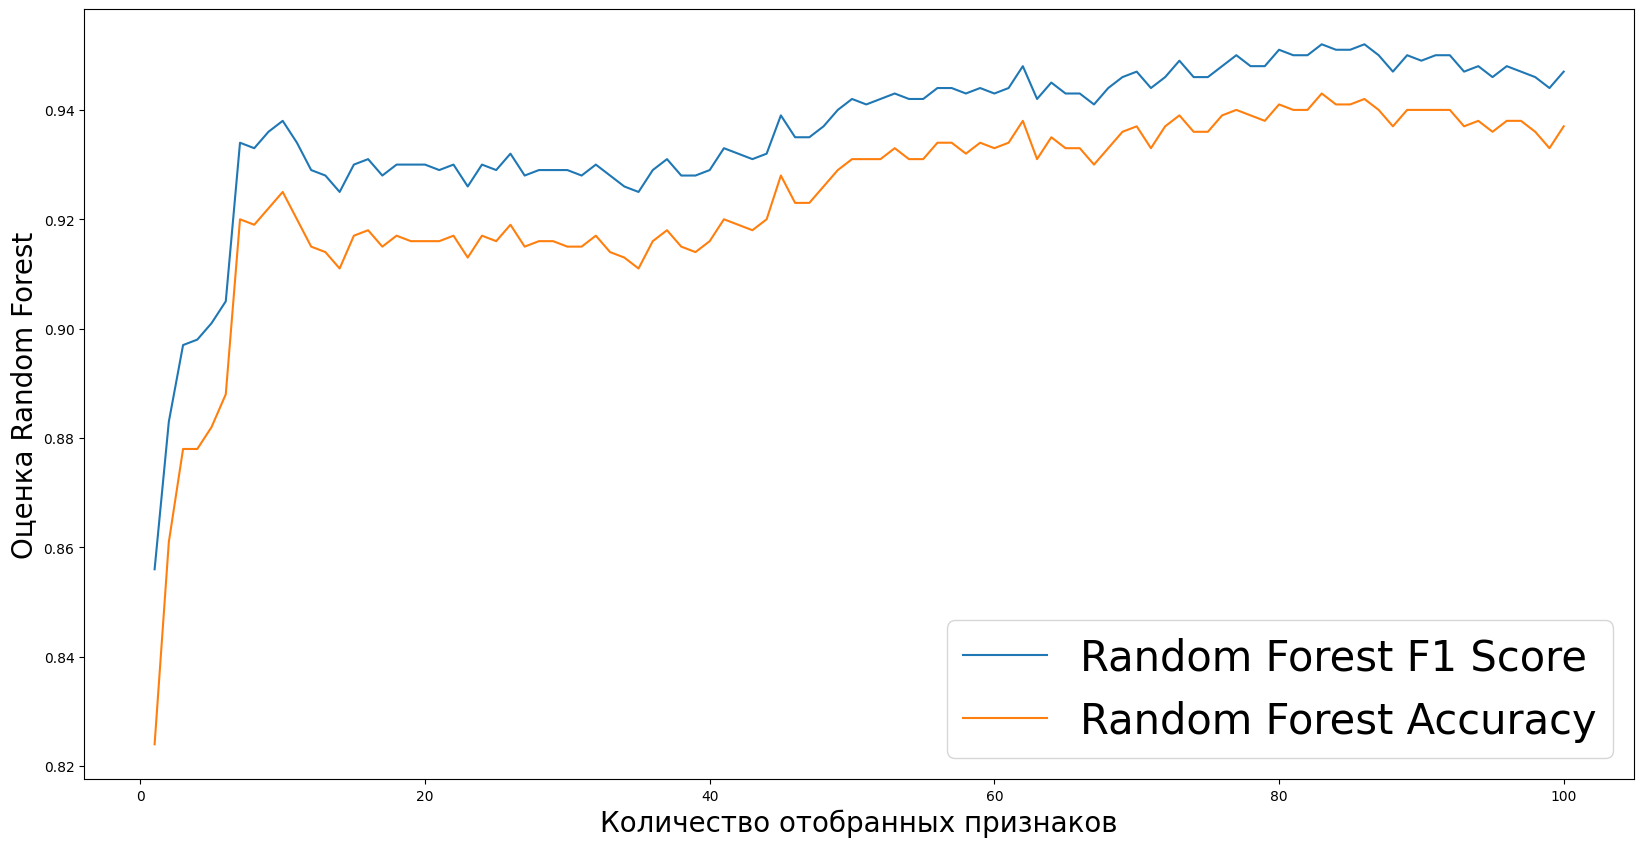

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_1_100.index, bst_features_1_100['Random forest F1 Score'], label='Random Forest F1 Score')
plt.plot(bst_features_1_100.index, bst_features_1_100['Random forest Accuracy'], label='Random Forest Accuracy')

plt.legend(prop={'size': 30})

Сократим с 1-100 до 5-30

In [ ]:
bst_features_5_30 = score_from_n_to_m_best_features(5, 30)
bst_features_5_30

,Random forest F1 Score,Random forest Accuracy
5,0.904,0.885
6,0.909,0.892
7,0.935,0.922
8,0.935,0.921
9,0.934,0.92
10,0.935,0.922
11,0.933,0.92
12,0.932,0.919
13,0.928,0.914
14,0.923,0.909


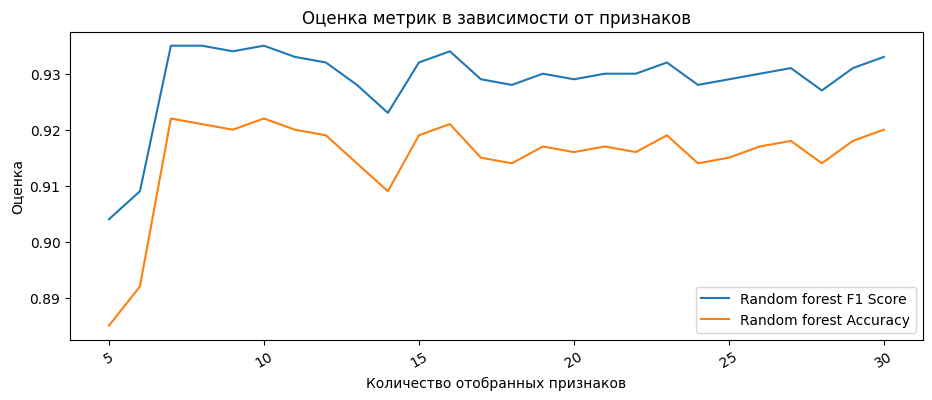

In [ ]:
plt.figure(figsize=(11, 4))
plt.xticks(rotation=30)

plt.ylabel("Oценка")
plt.xlabel("Количество отобранных признаков")

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_5_30.index, bst_features_5_30['Random forest F1 Score'], label='Random forest F1 Score')
plt.plot(bst_features_5_30.index, bst_features_5_30['Random forest Accuracy'], label='Random forest Accuracy')

plt.legend()

Сократим с 5-30 до 5-15

In [ ]:
bst_features_5_15 = score_from_n_to_m_best_features(5, 15)
bst_features_5_15

,Random forest F1 Score,Random forest Accuracy
5,0.906,0.887
6,0.904,0.887
7,0.936,0.923
8,0.928,0.914
9,0.934,0.92
10,0.938,0.926
11,0.935,0.922
12,0.931,0.918
13,0.927,0.913
14,0.923,0.909


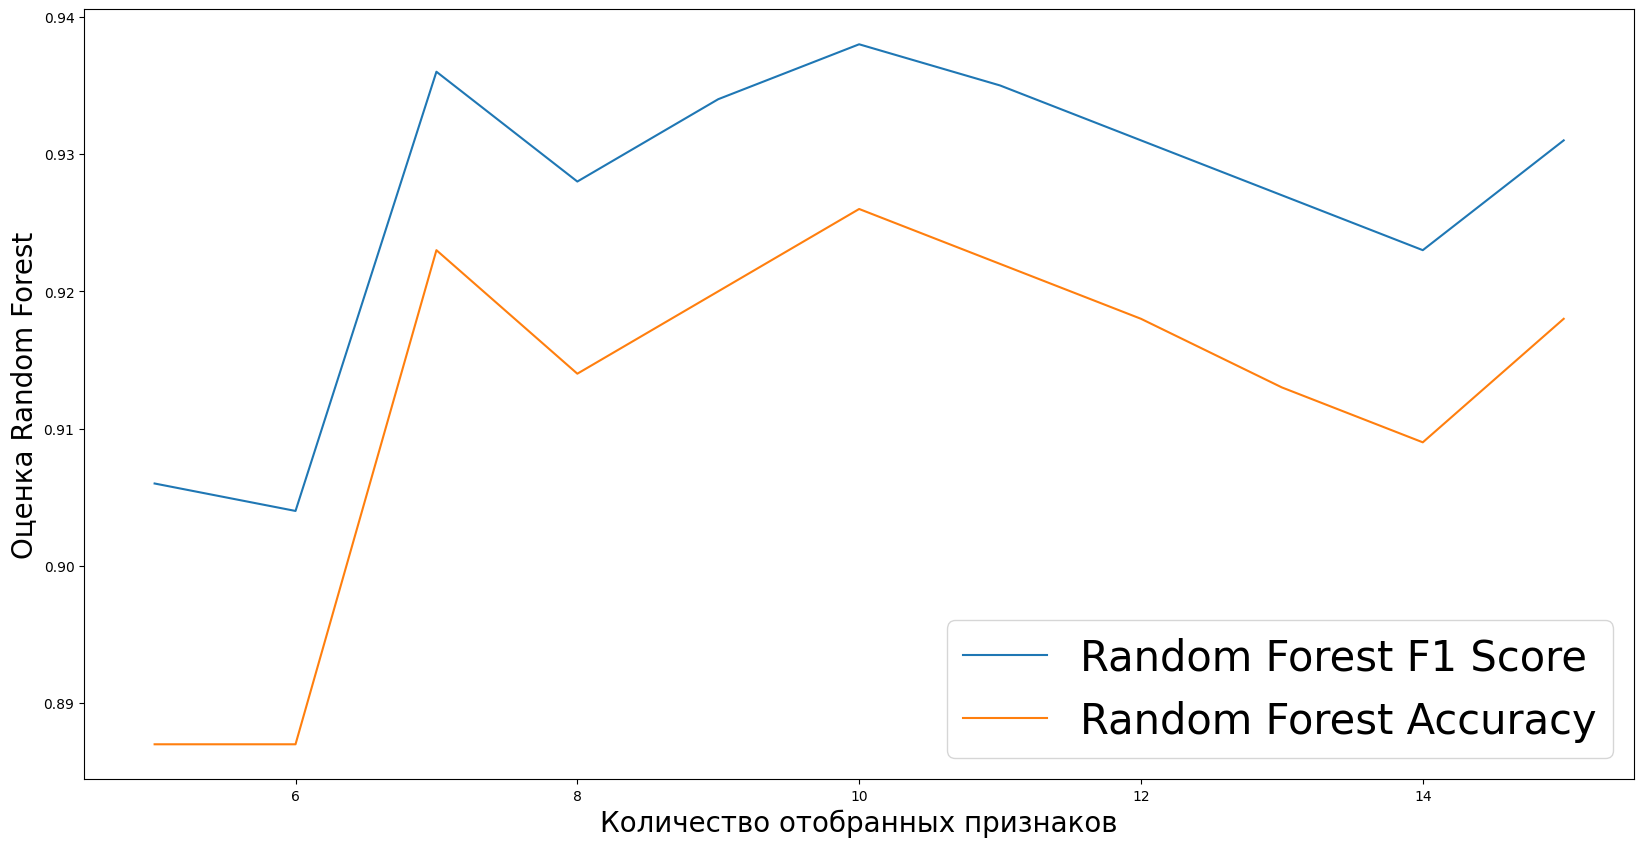

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_5_15.index, bst_features_5_15['Random forest F1 Score'], label='Random Forest F1 Score')
plt.plot(bst_features_5_15.index, bst_features_5_15['Random forest Accuracy'], label='Random Forest Accuracy')

plt.legend(prop={'size': 30})

Видно падение на 7 поэтому рассмотрим 6-12

In [ ]:
bst_features_6_12 = score_from_n_to_m_best_features(6, 12)
bst_features_6_12

,Random forest F1 Score,Random forest Accuracy
6,0.907,0.891
7,0.934,0.921
8,0.93,0.916
9,0.935,0.922
10,0.938,0.925
11,0.932,0.919
12,0.933,0.92


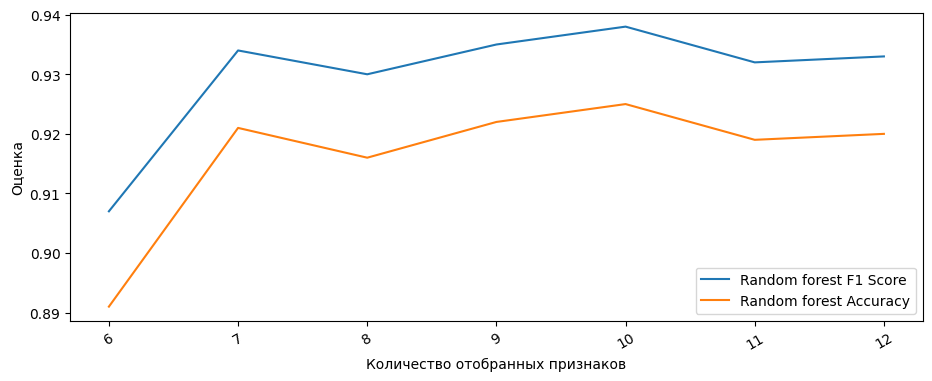

In [ ]:
plt.figure(figsize=(11, 4))
plt.xticks(rotation=30)

plt.ylabel("Oценка")
plt.xlabel("Количество отобранных признаков")

#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_6_12.index, bst_features_6_12['Random forest F1 Score'], label='Random forest F1 Score')
plt.plot(bst_features_6_12.index, bst_features_6_12['Random forest Accuracy'], label='Random forest Accuracy')

plt.legend()

Проведя серию экспериментов, с усредненными результатами, видно что идеальным выбором будет 7 либо 10 признаков

Рассмотрим метрики на 7 и 10 признаках

In [ ]:
df_best_7_features = df_best_n_features(7)
df_best_7_features

,2276,2254,2282,2316,2290,2310,3273,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14562.829102,14713.603516,14228.577148,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15562.816406,15772.785156,15149.055664,0
2,20234.121094,20282.953125,20402.167969,20457.568359,20322.167969,20513.652344,19699.015625,0
3,44321.910156,44553.687500,44583.531250,44758.605469,44647.730469,44725.585938,45610.453125,0
4,43332.187500,44180.933594,43104.050781,42258.046875,42727.699219,42505.140625,23579.816406,0
...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,1


In [ ]:
from sklearn.model_selection import train_test_split

X_7 = df_best_7_features.drop(['target'], axis=1)
y_7 = df_best_7_features['target']

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7, test_size=0.2, random_state=42)

In [ ]:
RF.fit(X_train_7, y_train_7)
y_pred_rf_7 = RF.predict(X_test_7)

cm_rf_7 = pd.DataFrame(confusion_matrix(y_test, y_pred_rf_7))
sensitivity = cm_rf_7[0][0] / (cm_rf_7[0][0] + cm_rf_7[1][0])
specificity = cm_rf_7[1][1] / (cm_rf_7[0][1] + cm_rf_7[1][1])

RF_7_metric = [accuracy_score(y_test_7, y_pred_rf_7), f1_score(y_test_7, y_pred_rf_7), specificity, sensitivity]
RF_7_metric

[0.9170731707317074,
 0.9311740890688259,
 0.9274193548387096,
 0.9012345679012346]

In [ ]:
RF.fit(X_train_10, y_train_10)
y_pred_rf_10 = RF.predict(X_test_10)

cm_rf_10 = pd.DataFrame(confusion_matrix(y_test, y_pred_rf_10))
sensitivity = cm_rf_10[0][0] / (cm_rf_10[0][0] + cm_rf_10[1][0])
specificity = cm_rf_10[1][1] / (cm_rf_10[0][1] + cm_rf_10[1][1])

RF_10_metric = [accuracy_score(y_test_10, y_pred_rf_10), f1_score(y_test_10, y_pred_rf_10), specificity, sensitivity]
RF_10_metric

[0.926829268292683, 0.9387755102040816, 0.9274193548387096, 0.9259259259259259]

In [ ]:
res['ВИ_7_лучших'] = RF_7_metric
res['ВИ_10_лучших'] = RF_10_metric

res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,ВИ_7_лучших,ВИ_10_лучших
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930,0.917,0.927
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939,0.931,0.939
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943,0.927,0.927
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912,0.901,0.926


In [ ]:
res.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_5',	'ENS_4',	'K_means_1',	'K_means_2',	'K_means_3'])

,RF,ENS_3,ВИ_7_лучших,ВИ_10_лучших
Точность,0.927,0.932,0.917,0.927
F1 мера,0.938,0.942,0.931,0.939
Доля верно обнаруженных больных,0.919,0.919,0.927,0.927
Доля верно обнаруженных здоровых,0.938,0.951,0.901,0.926


## 5.2. ExhaustiveFeatureSelector

Рассмотрим все комбинации от 6 до 8 из 10 самых информативных Raman Shift

In [ ]:
import joblib
import sklearn

sklearn.externals.joblib = joblib

print(sklearn.externals.joblib)

<module 'joblib' from '/usr/local/lib/python3.10/dist-packages/joblib/__init__.py'>


In [ ]:
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
from sklearn.model_selection import train_test_split

df_best_10_features = df_best_n_features(10)

X_10 = df_best_10_features.drop(['target'], axis=1)
y_10 = df_best_10_features['target']

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# создаем ExhaustiveFeatureSeLlector объект.
efs = ExhaustiveFeatureSelector(RandomForestClassifier(),
        min_features=6,
        max_features=8,
        scoring='f1',
        cv=2)

efs = efs.fit(X_train_10, y_train_10)

# выводим выбранные признаки
selected_features = X_train_10.columns[list(efs.best_idx_)]
print(selected_features)

Features: 375/375

Index([2276, 2254, 2282, 2316, 3273, 2313], dtype='object')


In [ ]:
df_t = df.T
df_efs = df_t.loc[selected_features]
df_efs = df_efs.T
df_efs['target'] = df.target
df_efs

,2276,2254,2282,2316,3273,2313,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14228.577148,14783.629883,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15149.055664,15838.429688,0
2,20234.121094,20282.953125,20402.167969,20457.568359,19699.015625,20673.751953,0
3,44321.910156,44553.687500,44583.531250,44758.605469,45610.453125,44840.671875,0
4,43332.187500,44180.933594,43104.050781,42258.046875,23579.816406,42436.707031,0
...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,29712.716797,22015.281250,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,29519.359375,22305.763672,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,29581.453125,22260.986328,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,29818.916016,22210.582031,1


In [ ]:
from sklearn.model_selection import train_test_split

X_efs1 = df_efs.drop(['target'], axis=1)
y_efs1 = df_efs['target']

X_efs1_train, X_efs1_test, y_efs1_train, y_efs1_test = train_test_split(X_efs1, y_efs1, test_size=0.2, random_state=42)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_efs1_train, y_efs1_train)
y_pred_efs1 = RF.predict(X_efs1_test)

cm_rf_efs = pd.DataFrame(confusion_matrix(y_efs1_test, y_pred_efs1))
sensitivity = cm_rf_efs[0][0] / (cm_rf_efs[0][0] + cm_rf_efs[1][0])
specificity = cm_rf_efs[1][1] / (cm_rf_efs[0][1] + cm_rf_efs[1][1])

RF_EFS_1_metric = [accuracy_score(y_efs1_test, y_pred_efs1), f1_score(y_efs1_test, y_pred_efs1), specificity, sensitivity]
RF_EFS_1_metric

[0.926829268292683, 0.9392712550607287, 0.9354838709677419, 0.9135802469135802]

рассмотрим все комбинации от 8 до 10 из 12 самых информативных Raman Shift

In [ ]:
from sklearn.model_selection import train_test_split

df_best_12_features = df_best_n_features(12)

X_12 = df_best_12_features.drop(['target'], axis=1)
y_12 = df_best_12_features['target']

X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X_12, y_12, test_size=0.2, random_state=42)

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# создаем ExhaustiveFeatureSeLlector объект.
efs = ExhaustiveFeatureSelector(RandomForestClassifier(),
        min_features=8,
        max_features=10,
        scoring='roc_auc',
        cv=2)

efs = efs.fit(X_train_12, y_train_12)

# выводим выбранные признаки
selected_features = X_train_12.columns[list(efs.best_idx_)]
print(selected_features)

Features: 781/781

Index([2276, 2254, 2282, 2316, 2310, 3273, 2313, 2271, 2322], dtype='object')


In [ ]:
feature_importances.head(12)

,Importance,Raman Shift
0,0.448217,2276
1,0.444072,2254
2,0.441974,2282
3,0.441940,2316
4,0.439378,2290
5,0.438947,2310
6,0.438489,3273
7,0.437977,2305
8,0.437881,2313
9,0.437477,2271


In [ ]:
df_t = df.T
df_efs = df_t.loc[selected_features]
df_efs = df_efs.T
df_efs['target'] = df.target
df_efs

,2276,2254,2282,2316,2310,3273,2313,2271,2322,target
0,14664.512695,14481.315430,14558.732422,14480.572266,14713.603516,14228.577148,14783.629883,14442.664063,14873.987305,0
1,15538.080078,15626.675781,15619.541016,15838.382813,15772.785156,15149.055664,15838.429688,15553.763672,15968.267578,0
2,20234.121094,20282.953125,20402.167969,20457.568359,20513.652344,19699.015625,20673.751953,20138.478516,20600.447266,0
3,44321.910156,44553.687500,44583.531250,44758.605469,44725.585938,45610.453125,44840.671875,43920.421875,44888.710938,0
4,43332.187500,44180.933594,43104.050781,42258.046875,42505.140625,23579.816406,42436.707031,43448.683594,42128.863281,0
...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22260.986328,29712.716797,22015.281250,22600.001953,22142.505859,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22210.582031,29519.359375,22305.763672,22568.464844,22233.488281,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22188.423828,29581.453125,22260.986328,22372.314453,22188.679688,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22215.191406,29818.916016,22210.582031,22655.052734,22373.847656,1


In [ ]:
from sklearn.model_selection import train_test_split

X_efs2 = df_efs.drop(['target'], axis=1)
y_efs2 = df_efs['target']

X_efs2_train, X_efs2_test, y_efs2_train, y_efs2_test = train_test_split(X_efs2, y_efs2, test_size=0.2, random_state=42)

In [ ]:
RF.fit(X_efs2_train, y_efs2_train)
y_pred_efs2 = RF.predict(X_efs2_test)

cm_rf_efs = pd.DataFrame(confusion_matrix(y_efs2_test, y_pred_efs2))
sensitivity = cm_rf_efs[0][0] / (cm_rf_efs[0][0] + cm_rf_efs[1][0])
specificity = cm_rf_efs[1][1] / (cm_rf_efs[0][1] + cm_rf_efs[1][1])

RF_EFS_2_metric = [accuracy_score(y_efs2_test, y_pred_efs2), f1_score(y_efs2_test, y_pred_efs2), specificity, sensitivity]
RF_EFS_2_metric

[0.9317073170731708, 0.943089430894309, 0.9354838709677419, 0.9259259259259259]

In [ ]:
res['RF_EFS_1_6_признаков'] = RF_EFS_1_metric
res['RF_EFS_2_9_признаков'] = RF_EFS_2_metric

res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930,0.917,0.927,0.927,0.932
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939,0.931,0.939,0.939,0.943
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943,0.927,0.927,0.935,0.935
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912,0.901,0.926,0.914,0.926


In [ ]:
res.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_5',	'ENS_4',	'K_means_1',	'K_means_2',	'K_means_3'])

,RF,ENS_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков
Точность,0.927,0.932,0.917,0.927,0.927,0.932
F1 мера,0.938,0.942,0.931,0.939,0.939,0.943
Доля верно обнаруженных больных,0.919,0.919,0.927,0.927,0.935,0.935
Доля верно обнаруженных здоровых,0.938,0.951,0.901,0.926,0.914,0.926


## 5.3. RFE

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

In [ ]:
def rfe_from_n_to_m_best_features_on_k_features(n, m, k):

  rfe_bst_features = pd.DataFrame(index=range(n, m + 1),columns=['RFE F1 Score', 'RFE Accuracy'])

  df_best_k_features = df_best_n_features(k)

  X_k = df_best_k_features.drop(['target'], axis=1)
  y_k = df_best_k_features['target']

  X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.2, random_state=42)

  for i in range (n, m + 1):

    _lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=10)

    rfe = RFE(_lr, n_features_to_select=i)
    rfe.fit(X_train_k, y_train_k)
    # X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
    y_pred_rfe = rfe.predict(X_test_k)

    f1_score_i = f1_score(y_test_k, y_pred_rfe)
    accuracy_i = accuracy_score(y_test_k, y_pred_rfe)

    #rfe_bst_features['RFE F1 Score'][i] = round(f1_score_i, 3)
    #rfe_bst_features['RFE Accuracy'][i] = round(accuracy_i, 3)

    rfe_bst_features['RFE F1 Score'][i] = f1_score_i
    rfe_bst_features['RFE Accuracy'][i] = accuracy_i
  return(rfe_bst_features)

In [ ]:
bst_features_1_50 = rfe_from_n_to_m_best_features_on_k_features(1, 50, 50)
bst_features_1_50

,RFE F1 Score,RFE Accuracy
1,0.0,0.395122
2,0.894737,0.882927
3,0.899563,0.887805
4,0.899563,0.887805
5,0.899563,0.887805
6,0.899563,0.887805
7,0.894737,0.882927
8,0.89083,0.878049
9,0.89083,0.878049
10,0.89083,0.878049


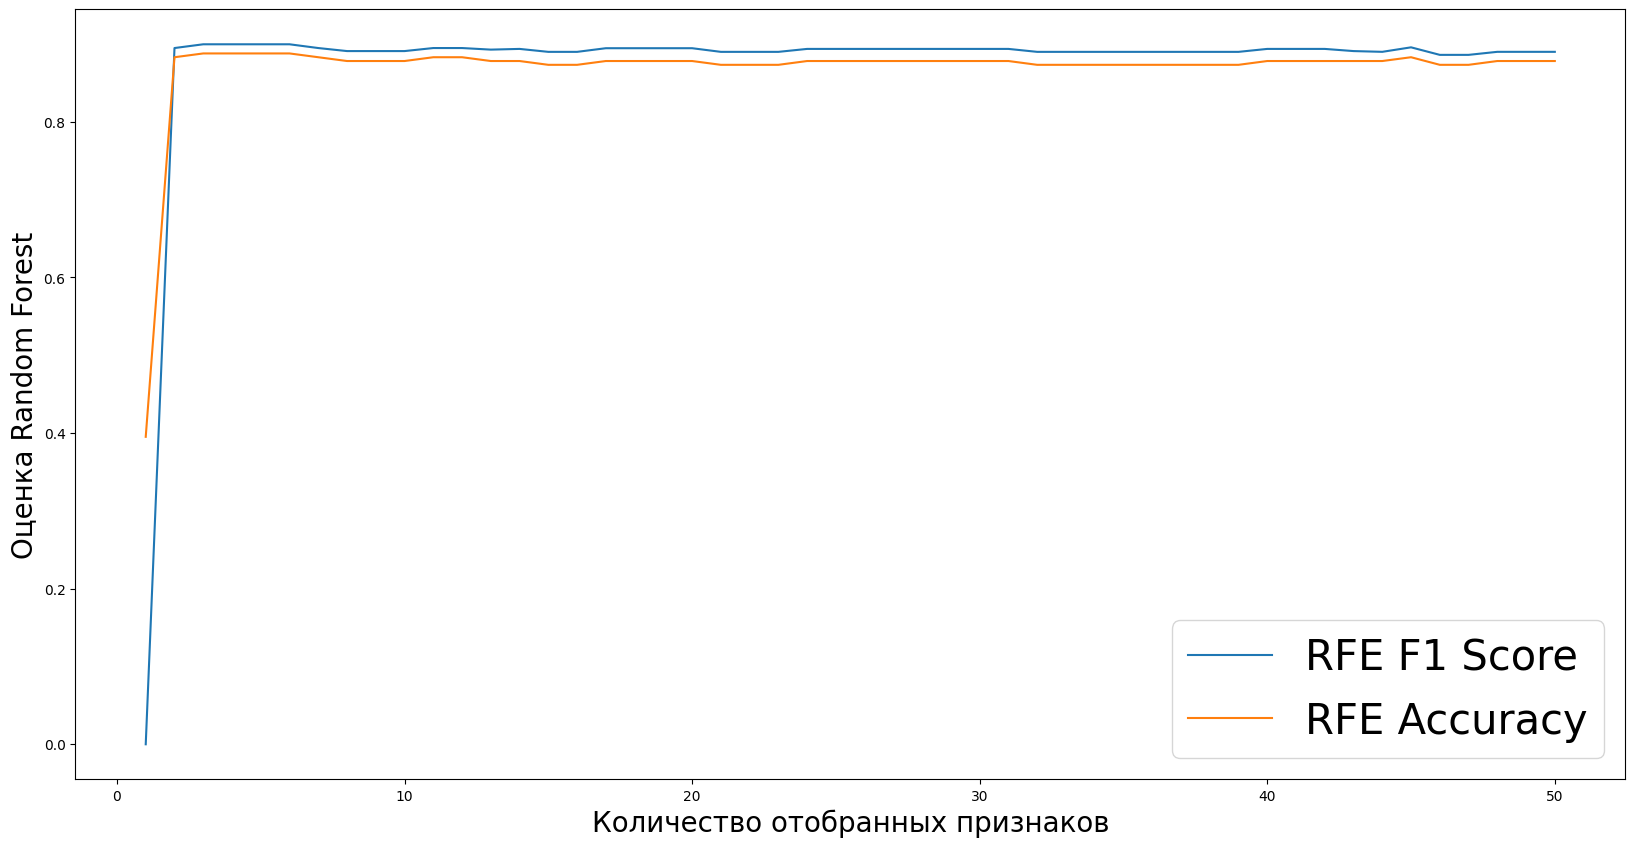

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_1_50.index, bst_features_1_50['RFE F1 Score'], label='RFE F1 Score')
plt.plot(bst_features_1_50.index, bst_features_1_50['RFE Accuracy'], label='RFE Accuracy')

plt.legend(prop={'size': 30})

In [ ]:
bst_features_5_30 = rfe_from_n_to_m_best_features_on_k_features(3, 30, 50)
bst_features_5_30

,RFE F1 Score,RFE Accuracy
3,0.899563,0.887805
4,0.899563,0.887805
5,0.899563,0.887805
6,0.899563,0.887805
7,0.894737,0.882927
8,0.89083,0.878049
9,0.89083,0.878049
10,0.89083,0.878049
11,0.894737,0.882927
12,0.894737,0.882927


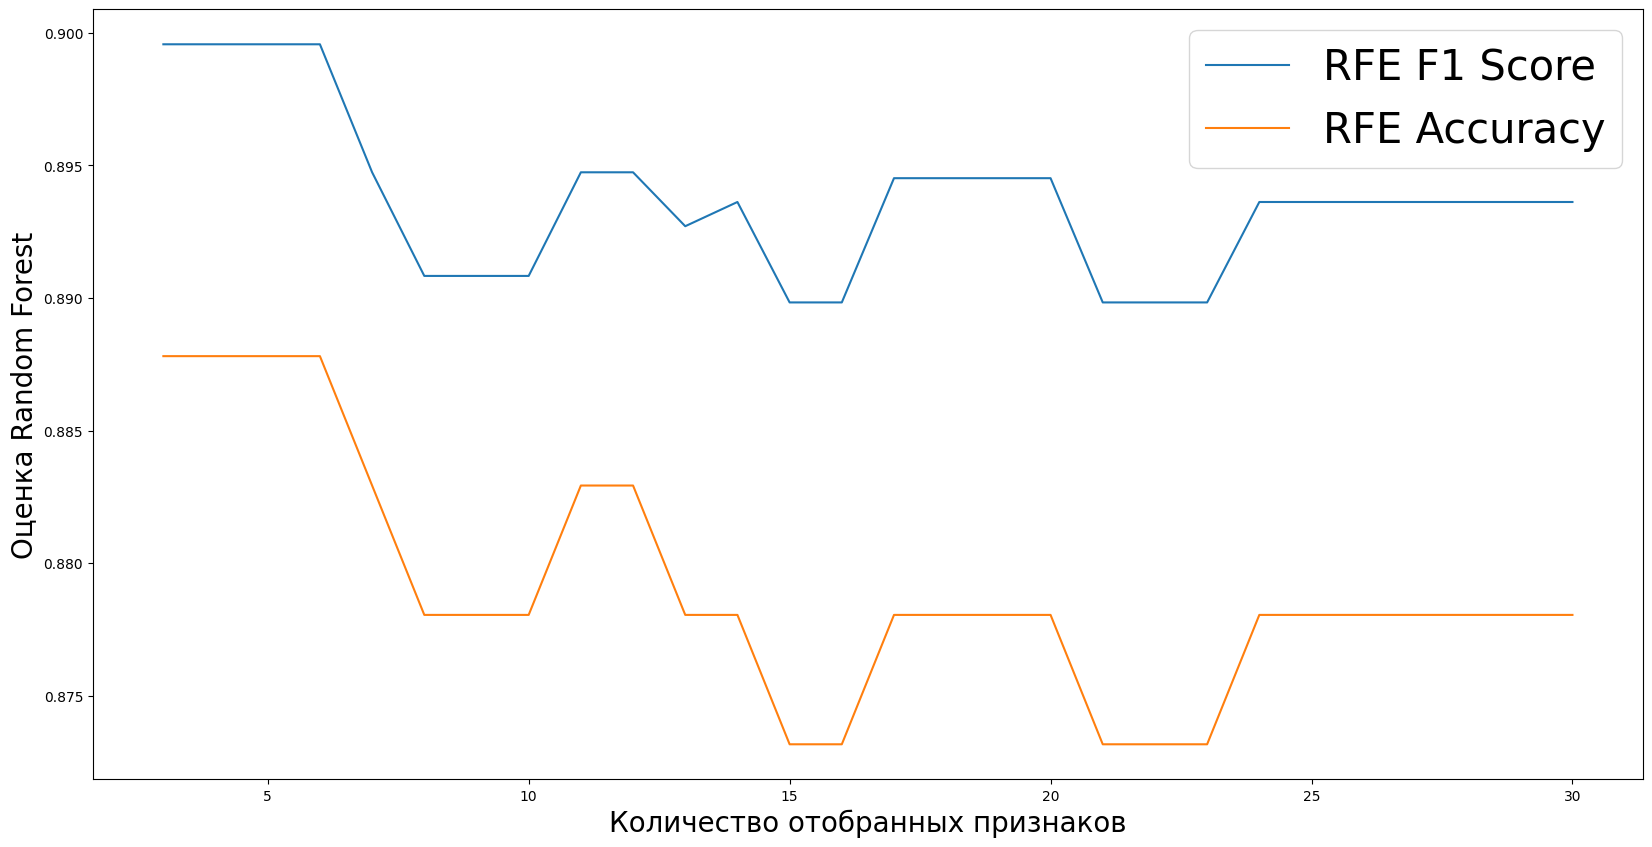

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)


#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_5_30.index, bst_features_5_30['RFE F1 Score'], label='RFE F1 Score')
plt.plot(bst_features_5_30.index, bst_features_5_30['RFE Accuracy'], label='RFE Accuracy')

plt.legend(prop={'size': 30})

Теперь посмотрим какие признаки встречались чаще всего

In [ ]:
def get_best_features(n, m, k):

  get_bst_features = pd.DataFrame(0, index=range(1, k + 1), columns=['Sum'])

  df_best_k_features = df_best_n_features(k)
  X_k = df_best_k_features.drop(['target'], axis=1)
  y_k = df_best_k_features['target']

  X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.2, random_state=42)

  for i in range (n, m + 1):

    _lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=10)

    rfe = RFE(_lr, n_features_to_select=i)
    rfe.fit(X_train_k, y_train_k)
    # X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
    y_pred_rfe = rfe.predict(X_test_k)

    F = pd.DataFrame(rfe.support_)
    F = F.astype(int)
    get_bst_features['Sum'] += F[0]  
  return(get_bst_features)

In [ ]:
get_bst_features_5_20 = get_best_features(5, 15, 20)
feat = feature_importances.head(20)
best_20_ftr_list = list(feat['Raman Shift'])
get_bst_features_5_20.index = best_20_ftr_list
get_bst_features_5_20 = get_bst_features_5_20.sort_values(by='Sum', ascending=False)
get_bst_features_5_20.head(10)

,Sum
2276,11.0
2310,11.0
2188,11.0
2313,11.0
2297,11.0
2254,9.0
2296,8.0
2317,7.0
3273,6.0
2316,5.0


In [ ]:
get_bst_features_5_20.head(10).index

Int64Index([2276, 2310, 2188, 2313, 2297, 2254, 2296, 2317, 3273, 2316], dtype='int64')

In [ ]:
ftr_list = [2276, 2310, 2188, 2313, 2297, 2254, 2296, 2317, 2262, 3273]
df_t = df.T
df_rfe = df_t.loc[ftr_list]
df_rfe = df_rfe.T
df_rfe['target'] = df.target
df_rfe

,2276,2310,2188,2313,2297,2254,2296,2317,2262,3273,target
0,14664.512695,14713.603516,14486.275391,14783.629883,14616.062500,14481.315430,14862.954102,14790.139648,14534.288086,14228.577148,0
1,15538.080078,15772.785156,15606.049805,15838.429688,15705.835938,15626.675781,15662.459961,15786.562500,15609.454102,15149.055664,0
2,20234.121094,20513.652344,20328.085938,20673.751953,20479.531250,20282.953125,20407.072266,20778.542969,20156.101563,19699.015625,0
3,44321.910156,44725.585938,44401.796875,44840.671875,44756.230469,44553.687500,44417.007813,44855.648438,44095.003906,45610.453125,0
4,43332.187500,42505.140625,46601.050781,42436.707031,42895.996094,44180.933594,42763.679688,42397.203125,43524.628906,23579.816406,0
...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22260.986328,22324.660156,22015.281250,22523.562500,22600.992188,22377.355469,22373.847656,22667.013672,29712.716797,1
1018,22541.402344,22210.582031,22356.267578,22305.763672,22377.355469,22647.896484,22364.574219,22315.832031,22682.205078,29519.359375,1
1019,22521.099609,22188.423828,22443.265625,22260.986328,22364.574219,22500.722656,22333.017578,22474.501953,22564.750000,29581.453125,1
1020,22600.001953,22215.191406,22692.705078,22210.582031,22333.017578,22652.085938,22258.292969,22015.281250,22385.714844,29818.916016,1


In [ ]:
from sklearn.model_selection import train_test_split

X_rfe = df_rfe.drop(['target'], axis=1)
y_rfe = df_rfe['target']

X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.2, random_state=42)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_rfe_train, y_rfe_train)
y_pred_rfe = RF.predict(X_rfe_test)

cm_rf_rfe = pd.DataFrame(confusion_matrix(y_rfe_test, y_pred_rfe))
sensitivity = cm_rf_rfe[0][0] / (cm_rf_rfe[0][0] + cm_rf_rfe[1][0])
specificity = cm_rf_rfe[1][1] / (cm_rf_rfe[0][1] + cm_rf_rfe[1][1])

RF_RFE_metric = [accuracy_score(y_rfe_test, y_pred_rfe), f1_score(y_rfe_test, y_pred_rfe), specificity, sensitivity]
RF_RFE_metric

[0.926829268292683, 0.9397590361445783, 0.9435483870967742, 0.9012345679012346]

In [ ]:
res['RFE'] = RF_RFE_metric
res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков,RFE
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930,0.917,0.927,0.927,0.932,0.927
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939,0.931,0.939,0.939,0.943,0.940
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943,0.927,0.927,0.935,0.935,0.944
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912,0.901,0.926,0.914,0.926,0.901


In [ ]:
_res = res.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_5',	'ENS_4',	'K_means_1',	'K_means_2',	'K_means_3'])
_res.rename(columns = {'ВИ_7_лучших':'RF_ВИ_7', 'ВИ_10_лучших':'RF_ВИ_10', 'RF_EFS_1_6_признаков':'RF_EFS_6', 'RF_EFS_2_9_признаков':'RF_EFS_9'}, inplace = True )
_res

,RF,ENS_3,RF_ВИ_7,RF_ВИ_10,RF_EFS_6,RF_EFS_9,RFE
Точность,0.927,0.932,0.917,0.927,0.927,0.932,0.927
F1 мера,0.938,0.942,0.931,0.939,0.939,0.943,0.940
Доля верно обнаруженных больных,0.919,0.919,0.927,0.927,0.935,0.935,0.944
Доля верно обнаруженных здоровых,0.938,0.951,0.901,0.926,0.914,0.926,0.901


## 5.4. Random Forest Importance

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# создаем случайное дерево с вашими гипер параметрами
model = RandomForestClassifier(n_estimators=100)

# Обучаем модель на вашей выборке; Где X, y - входные и выходные данные соответственно.
model.fit(X, y)

# Подбираем самые важные признаки
importances = model.feature_importances_

# Создаем отдельный датасет для визуализации
final_df = pd.DataFrame({"Raman Shift" : pd.DataFrame(X).columns, "Importances" : importances})
final_df

,Raman Shift,Importances
0,2141,0.008206
1,2142,0.004591
2,2144,0.004531
3,2145,0.009315
4,2147,0.012117
...,...,...
1010,3545,0.003641
1011,3546,0.008003
1012,3547,0.011476
1013,3549,0.000999


<Axes: xlabel='Raman Shift'>

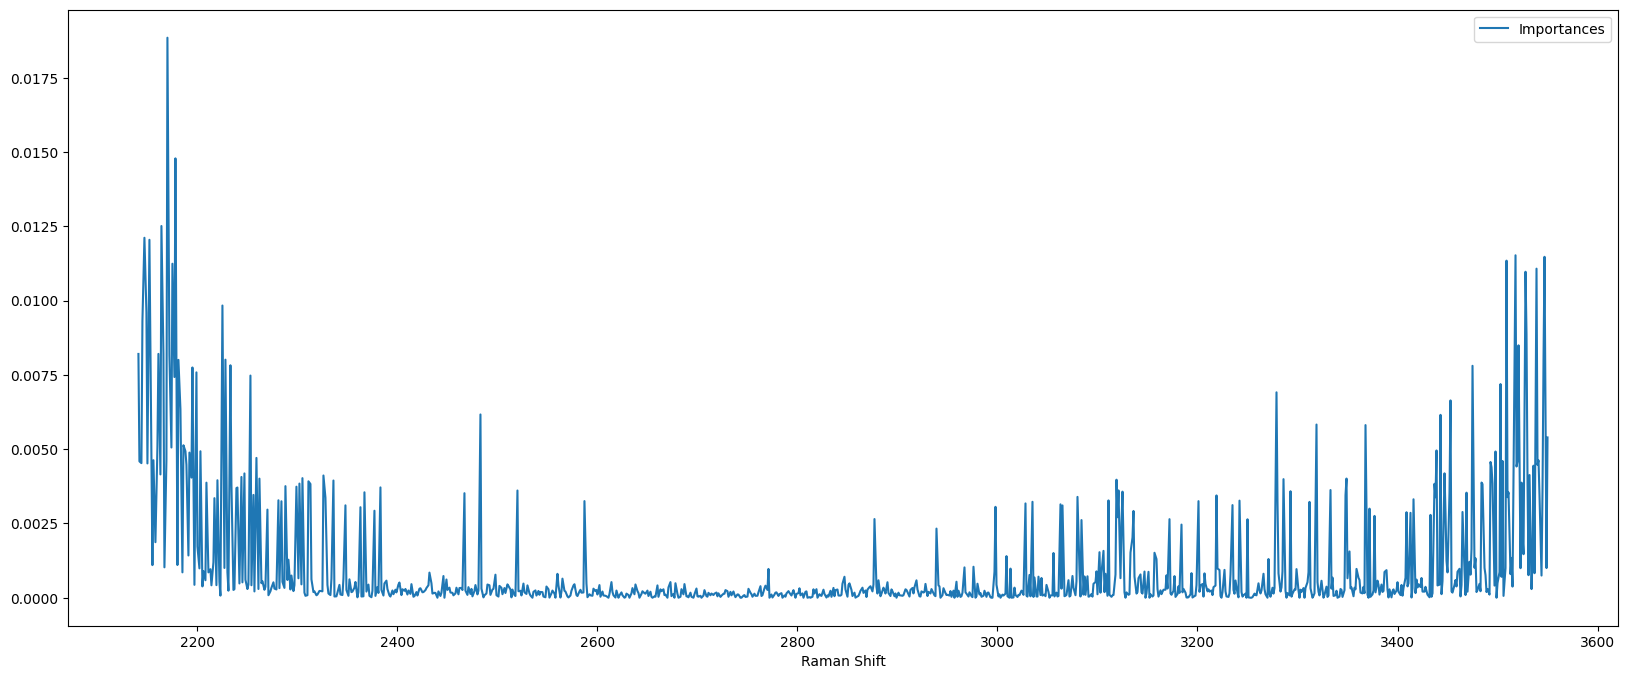

In [ ]:
final_df.plot(x = 'Raman Shift', y = 'Importances', figsize=(20, 8))

In [ ]:
final_df_sort = final_df.sort_values(by=['Importances'], ascending=False)
final_df_sort

,Raman Shift,Importances
19,2170,0.018851
24,2178,0.014789
15,2164,0.012512
4,2147,0.012117
7,2152,0.012049
...,...,...
311,2611,0.000000
827,3315,0.000000
433,2785,0.000000
871,3371,0.000000


In [ ]:
def df_best_n_features_rfi(n):

  n_features = final_df_sort.head(n)
  best_n_ftr_list = list(n_features['Raman Shift'])

  df_t = df.T
  df_best_n_features = df_t.loc[best_n_ftr_list]
  df_best_n_features = df_best_n_features.T
  df_best_n_features['target'] = df.target

  return(df_best_n_features)

In [ ]:
def score_from_n_to_m_best_features_rfi(n, m):

  bst_features = pd.DataFrame(index=range(n, m + 1),columns=['RFI F1 Score', 'RFI Accuracy'])

  for i in range (n, m + 1):

    f1_score_i = 0
    accuracy_i = 0

    df_best_i_features = df_best_n_features_rfi(i)

    for j in range (10):
      X_i = df_best_i_features.drop(['target'], axis=1)
      y_i = df_best_i_features['target']
      X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

      RF = RandomForestClassifier()
      RF.fit(X_train_i, y_train_i)
      y_pred_rf_i = RF.predict(X_test_i)
      f1_score_i += f1_score(y_test_i, y_pred_rf_i)
      accuracy_i += accuracy_score(y_test_i, y_pred_rf_i)

    bst_features['RFI F1 Score'][i] = round(f1_score_i / 10, 3)
    bst_features['RFI Accuracy'][i] = round(accuracy_i / 10, 3)

  return(bst_features)

In [ ]:
rfi_1_50 = score_from_n_to_m_best_features_rfi(1, 50)
rfi_1_50

,RFI F1 Score,RFI Accuracy
1,0.842,0.815
2,0.877,0.855
3,0.944,0.933
4,0.944,0.933
5,0.943,0.932
6,0.941,0.929
7,0.947,0.936
8,0.943,0.931
9,0.944,0.933
10,0.944,0.933


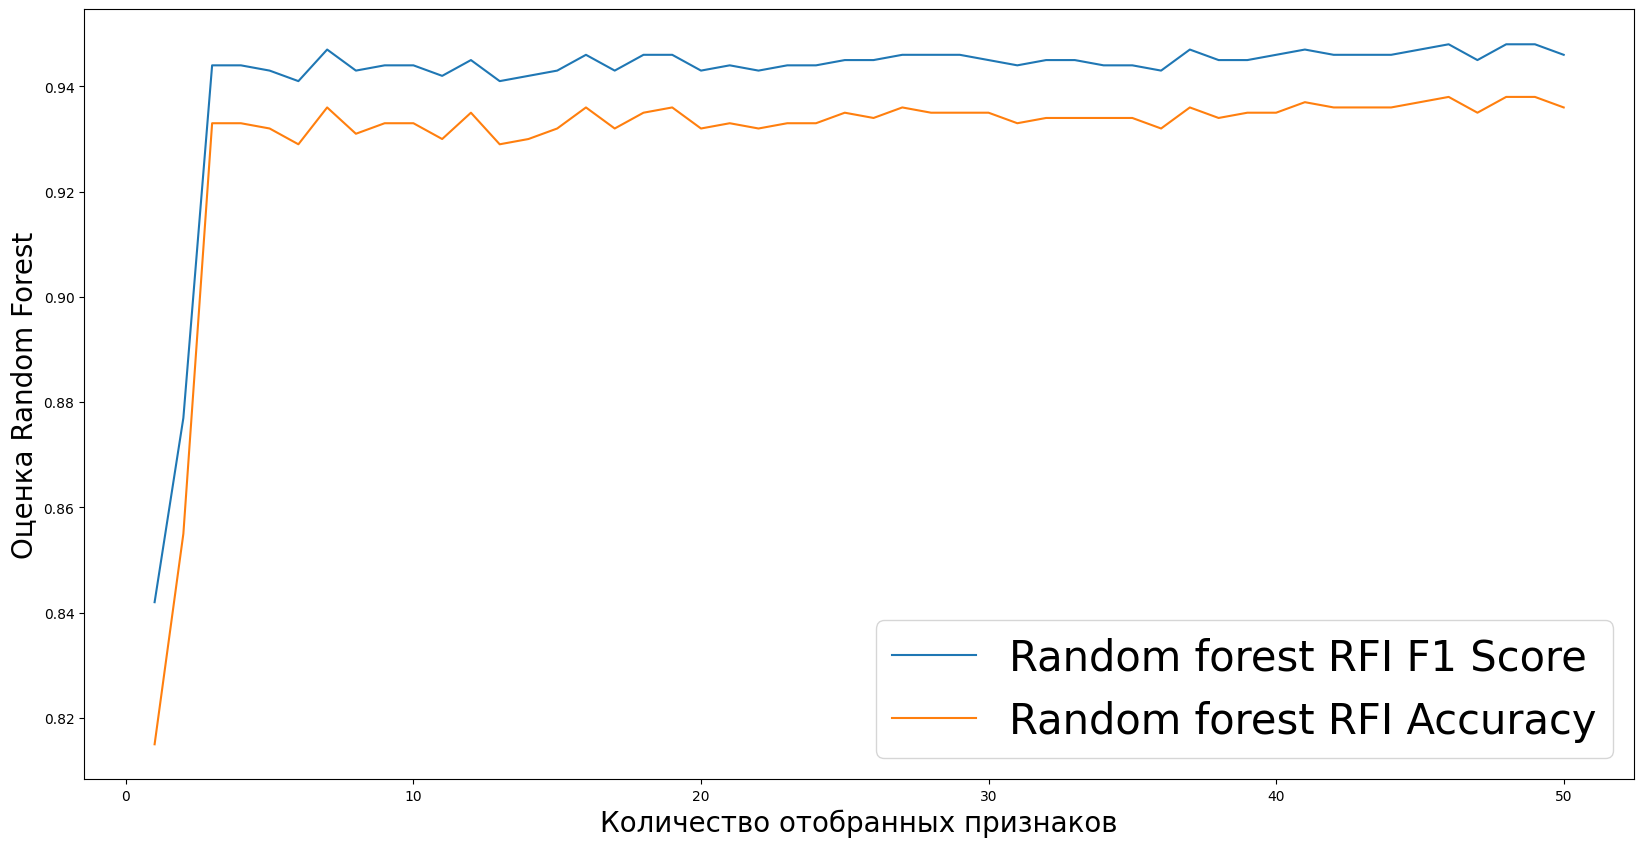

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(rfi_1_50.index, rfi_1_50['RFI F1 Score'], label='Random forest RFI F1 Score')
plt.plot(rfi_1_50.index, rfi_1_50['RFI Accuracy'], label='Random forest RFI Accuracy')

plt.legend(prop={'size': 30})

In [ ]:
rfi_7_15 = score_from_n_to_m_best_features_rfi(7, 15)
rfi_7_15

,RFI F1 Score,RFI Accuracy
7,0.942,0.93
8,0.943,0.931
9,0.944,0.933
10,0.943,0.932
11,0.943,0.931
12,0.941,0.929
13,0.941,0.929
14,0.942,0.931
15,0.942,0.93


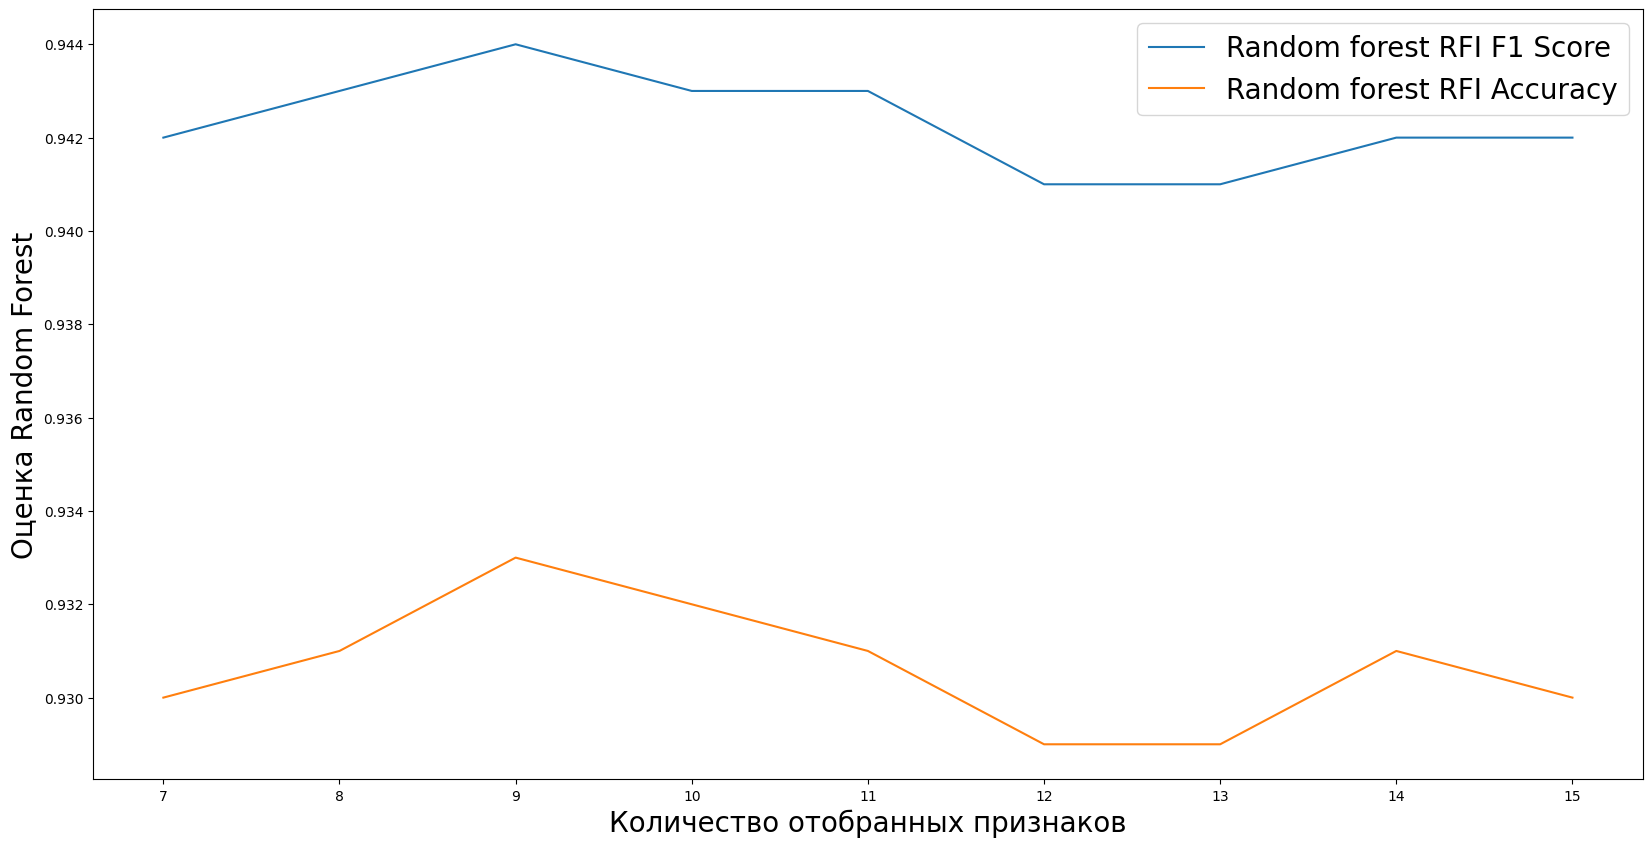

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

#plt.title('Оценка метрик в зависимости от признаков')

plt.plot(rfi_7_15.index, rfi_7_15['RFI F1 Score'], label='Random forest RFI F1 Score')
plt.plot(rfi_7_15.index, rfi_7_15['RFI Accuracy'], label='Random forest RFI Accuracy')

plt.legend(prop={'size': 20})

In [ ]:
rfi_9_features = df_best_n_features_rfi(9)
rfi_9_features

,2186,2142,3537,2177,2152,2149,3544,2147,2185,target
0,14461.596680,14564.058594,12946.255859,14598.019531,14535.691406,14643.199219,12854.240234,14588.244141,14552.708008,0
1,15844.866211,15418.325195,13863.434570,15633.852539,15711.148438,15514.342773,13853.833008,15582.207031,15647.779297,0
2,20313.146484,20117.593750,18079.205078,20344.082031,20185.882813,20208.925781,18273.623047,20384.230469,20327.158203,0
3,44872.781250,44447.613281,44238.281250,44677.500000,44328.511719,44669.843750,43904.894531,44670.976563,44624.726563,0
4,46738.519531,48108.988281,20485.710938,46874.371094,47203.949219,47655.687500,20578.878906,47734.351563,46623.441406,0
...,...,...,...,...,...,...,...,...,...,...
1017,22356.267578,22311.207031,30257.056641,22418.267578,22451.833984,22589.820313,30515.199219,22543.992188,22443.265625,1
1018,22443.265625,22480.119141,30718.039063,22582.566406,22507.066406,22543.992188,30520.667969,22512.871094,22692.705078,1
1019,22692.705078,22372.001953,30266.238281,22564.251953,22589.820313,22512.871094,30293.595703,22580.873047,22476.832031,1
1020,22476.832031,22623.326172,30299.158203,22470.365234,22543.992188,22580.873047,30500.468750,22311.207031,22377.328125,1


In [ ]:
rfi_9_features.columns

Index([2186, 2142, 3537, 2177, 2152, 2149, 3544, 2147, 2185, 'target'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

X_rfi = rfi_9_features.drop(['target'], axis=1)
y_rfi = rfi_9_features['target']

X_rfi_train, X_rfi_test, y_rfi_train, y_rfi_test = train_test_split(X_rfi, y_rfi, test_size=0.2, random_state=42)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_rfi_train, y_rfi_train)
y_pred_rfi = RF.predict(X_rfi_test)

cm_rf_rfi = pd.DataFrame(confusion_matrix(y_rfi_test, y_pred_rfi))
sensitivity = cm_rf_rfi[0][0] / (cm_rf_rfi[0][0] + cm_rf_rfi[1][0])
specificity = cm_rf_rfi[1][1] / (cm_rf_rfi[0][1] + cm_rf_rfi[1][1])

RF_RFI_metric = [accuracy_score(y_rfi_test, y_pred_rfi), f1_score(y_rfi_test, y_pred_rfi), specificity, sensitivity]
RF_RFI_metric

[0.9365853658536586, 0.946938775510204, 0.9354838709677419, 0.9382716049382716]

In [ ]:
res['RFI'] = RF_RFI_metric
res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков,RFE,RFI
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930,0.917,0.927,0.927,0.932,0.927,0.937
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939,0.931,0.939,0.939,0.943,0.940,0.947
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943,0.927,0.927,0.935,0.935,0.944,0.935
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912,0.901,0.926,0.914,0.926,0.901,0.938


In [ ]:
_res = res.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_5',	'ENS_4',	'K_means_1',	'K_means_2',	'K_means_3'])
_res.rename(columns = {'ВИ_7_лучших':'RF_ВИ_7', 'ВИ_10_лучших':'RF_ВИ_10', 'RF_EFS_1_6_признаков':'RF_EFS_6', 'RF_EFS_2_9_признаков':'RF_EFS_9'}, inplace = True )
_res

,RF,ENS_3,RF_ВИ_7,RF_ВИ_10,RF_EFS_6,RF_EFS_9,RFE,RFI
Точность,0.927,0.932,0.917,0.927,0.927,0.932,0.927,0.937
F1 мера,0.938,0.942,0.931,0.939,0.939,0.943,0.940,0.947
Доля верно обнаруженных больных,0.919,0.919,0.927,0.927,0.935,0.935,0.944,0.935
Доля верно обнаруженных здоровых,0.938,0.951,0.901,0.926,0.914,0.926,0.901,0.938


## 5.5. PCA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

_data = df.drop(['target'], axis=1)

PCA_output = PCA(n_components=10)
PCA_output.fit(_data)
sklearn_transformed_data = PCA_output.transform(_data)

In [ ]:
_PCA = pd.DataFrame(sklearn_transformed_data)
_PCA['target'] = df.target
_PCA

,0,1,2,3,4,5,6,7,8,9,target
0,-916614.346465,-15401.771315,-14213.686623,216.668062,-3337.235007,3466.457971,-1811.833747,-1252.301692,-342.411768,-191.210166,1
1,-584307.540581,-4346.092803,-2432.298588,-1879.301738,-3203.479555,2107.297593,-1740.620138,-1036.871893,-327.849823,-612.283487,1
2,-107020.485296,74048.701675,9708.560013,-7283.442265,172.797179,-527.575234,448.806852,-446.710294,769.645970,693.383985,1
3,527437.979237,-95997.102738,31944.404963,-8361.771625,-2066.967105,1053.458771,492.621109,-1183.044985,-266.264968,-3623.823303,1
4,133104.920336,76359.121014,16585.863077,-11219.613297,1175.634921,-1923.852599,1455.308445,-91.932866,595.342056,140.817546,1
...,...,...,...,...,...,...,...,...,...,...,...
1017,-575192.513056,-98758.662750,442.984842,51719.692879,-22688.276456,14987.848793,-8300.561637,-2877.985348,-3418.067827,-5621.431958,1
1018,-575452.691790,-98671.440477,540.103820,51690.929583,-22799.008067,15031.996426,-8547.222706,-2769.791381,-3429.805365,-5470.203395,1
1019,-575711.839933,-98564.445260,640.704921,51672.159210,-22893.002658,15087.330340,-8791.701077,-2657.098565,-3430.554009,-5213.892491,1
1020,-575960.848088,-98455.140645,760.116350,51663.064032,-22961.365138,15132.696563,-9000.311661,-2536.420491,-3411.105812,-4961.866664,1


In [ ]:
from sklearn.model_selection import train_test_split

X_pca = _PCA.drop(['target'], axis=1)
y_pca = _PCA['target']
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train_pca, y_train_pca)

RandomForestClassifier()

In [ ]:
y_pred_rf = RF.predict(X_test_pca)

print(f'Random forest F1 Score {f1_score(y_test_pca, y_pred_rf)}')
print(f'Random forest Accuracy {accuracy_score(y_test_pca, y_pred_rf)}')

Random forest F1 Score 0.9623430962343097
Random forest Accuracy 0.9560975609756097


In [ ]:
def pca_from_n_to_m_components(n, m):

  pca = pd.DataFrame(index=range(n, m + 1),columns=['Random forest PCA Accuracy', 'Random forest PCA F1 Score', 'Random forest PCA Specificity', 'Random forest PCA Sensitivity'])

  _data = df.drop(['target'], axis=1)

  for i in range (n, m + 1):

    f1_score_i = 0
    accuracy_i = 0
    sensitivity_i = 0
    specificity_i = 0

    for j in range (10):

      PCA_output = PCA(n_components=i)
      PCA_output.fit(_data)
      sklearn_transformed_data = PCA_output.transform(_data)
      _PCA = pd.DataFrame(sklearn_transformed_data)
      _PCA['target'] = df.target

      X_pca = _PCA.drop(['target'], axis=1)
      y_pca = _PCA['target']
      X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

      RF = RandomForestClassifier()
      RF.fit(X_train_pca, y_train_pca)
      y_pred_pca = RF.predict(X_test_pca)

      cm = pd.DataFrame(confusion_matrix(y_test_pca, y_pred_pca))
      sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
      specificity = cm[1][1] / (cm[0][1] + cm[1][1])

      f1_score_i += f1_score(y_test_pca, y_pred_pca)
      accuracy_i += accuracy_score(y_test_pca, y_pred_pca)
      sensitivity_i += sensitivity
      specificity_i += specificity

    pca['Random forest PCA F1 Score'][i] = round(f1_score_i / 10, 3)
    pca['Random forest PCA Accuracy'][i] = round(accuracy_i / 10, 3)
    pca['Random forest PCA Specificity'][i] = round(specificity_i / 10, 3)
    pca['Random forest PCA Sensitivity'][i] = round(sensitivity_i / 10, 3)

  return(pca)

In [ ]:
pca_1_to_50 = pca_from_n_to_m_components(1, 50)
pca_1_to_50

,Random forest PCA Accuracy,Random forest PCA F1 Score,Random forest PCA Specificity,Random forest PCA Sensitivity
1,0.751,0.783,0.742,0.765
2,0.923,0.936,0.925,0.921
3,0.937,0.946,0.919,0.963
4,0.938,0.947,0.922,0.963
5,0.936,0.945,0.915,0.968
6,0.932,0.942,0.91,0.964
7,0.943,0.951,0.922,0.975
8,0.942,0.95,0.921,0.974
9,0.945,0.953,0.926,0.975
10,0.95,0.958,0.935,0.973


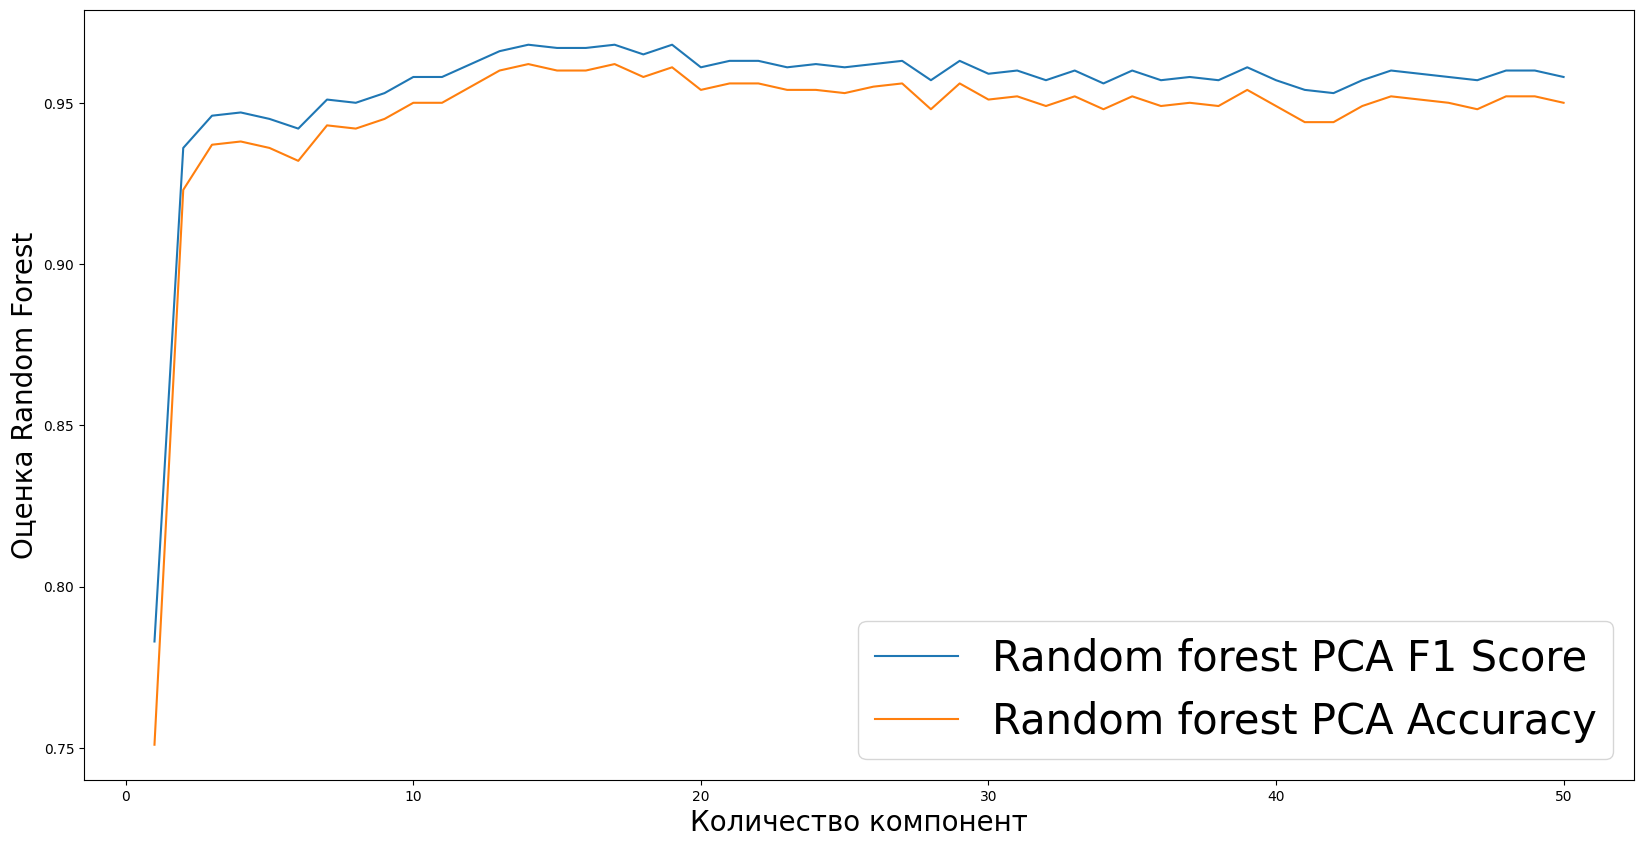

In [ ]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество компонент", fontsize=20)

#plt.title('Оценка метрик в зависимости от количества компонент в PCA')

plt.plot(pca_1_to_50.index, pca_1_to_50['Random forest PCA F1 Score'], label='Random forest PCA F1 Score')
plt.plot(pca_1_to_50.index, pca_1_to_50['Random forest PCA Accuracy'], label='Random forest PCA Accuracy')

plt.legend(prop={'size': 30})

In [ ]:
pca_5_to_20 = pca_from_n_to_m_components(5, 20)
pca_5_to_20

,Random forest PCA Accuracy,Random forest PCA F1 Score,Random forest PCA Specificity,Random forest PCA Sensitivity
5,0.933,0.943,0.913,0.964
6,0.935,0.945,0.914,0.968
7,0.943,0.951,0.923,0.974
8,0.944,0.953,0.926,0.973
9,0.943,0.951,0.923,0.973
10,0.951,0.958,0.936,0.973
11,0.957,0.964,0.944,0.978
12,0.957,0.964,0.944,0.977
13,0.964,0.97,0.957,0.974
14,0.96,0.967,0.948,0.979


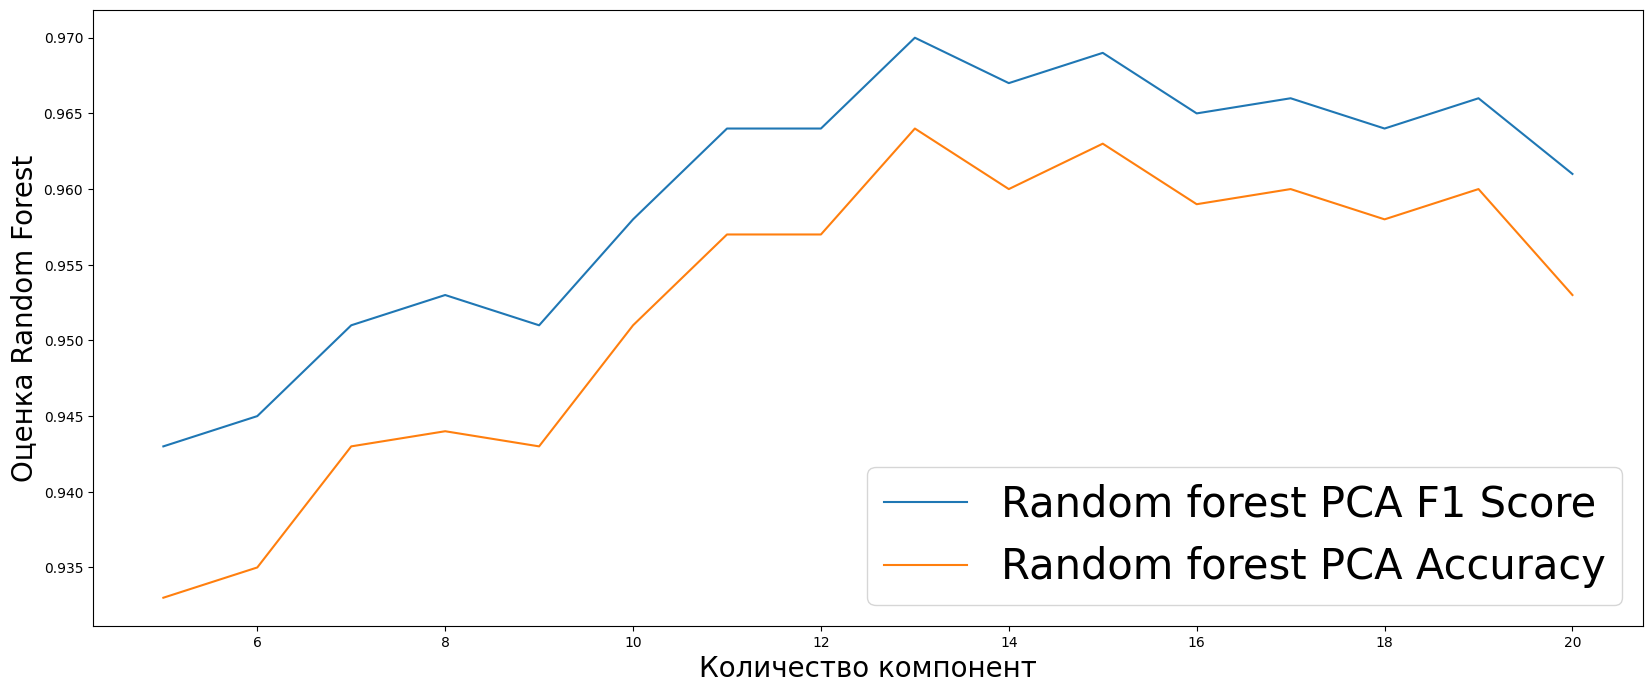

In [ ]:
plt.figure(figsize=(20, 8))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество компонент", fontsize=20)

#plt.title('Оценка метрик в зависимости от количества компонент в PCA')

plt.plot(pca_5_to_20.index, pca_5_to_20['Random forest PCA F1 Score'], label='Random forest PCA F1 Score')
plt.plot(pca_5_to_20.index, pca_5_to_20['Random forest PCA Accuracy'], label='Random forest PCA Accuracy')

plt.legend(prop={'size': 30})

In [ ]:
pca_5_to_20 = pca_5_to_20.T

In [ ]:
res['PCA_8'] = list(pca_5_to_20[8])
res['PCA_13'] = list(pca_5_to_20[13])

res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков,RFE,RFI,PCA_8,PCA_13
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930,0.917,0.927,0.927,0.932,0.927,0.937,0.944,0.964
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939,0.931,0.939,0.939,0.943,0.940,0.947,0.953,0.970
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943,0.927,0.927,0.935,0.935,0.944,0.935,0.926,0.957
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912,0.901,0.926,0.914,0.926,0.901,0.938,0.973,0.974


In [ ]:
_res = res.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_5',	'ENS_4',	'K_means_1',	'K_means_2',	'K_means_3'])
_res.rename(columns = {'ВИ_7_лучших':'RF_ВИ_7', 'ВИ_10_лучших':'RF_ВИ_10', 'RF_EFS_1_6_признаков':'RF_EFS_6', 'RF_EFS_2_9_признаков':'RF_EFS_9'}, inplace = True )
_res

,RF,ENS_3,RF_ВИ_7,RF_ВИ_10,RF_EFS_6,RF_EFS_9,RFE,RFI,PCA_8,PCA_13
Точность,0.927,0.932,0.917,0.927,0.927,0.932,0.927,0.937,0.944,0.964
F1 мера,0.938,0.942,0.931,0.939,0.939,0.943,0.940,0.947,0.953,0.970
Доля верно обнаруженных больных,0.919,0.919,0.927,0.927,0.935,0.935,0.944,0.935,0.926,0.957
Доля верно обнаруженных здоровых,0.938,0.951,0.901,0.926,0.914,0.926,0.901,0.938,0.973,0.974


In [ ]:
res.to_csv('all_result.zip', index=False, compression=compression_opts) 

In [ ]:
#res = pd.read_csv('result.csv')
#res.index = ['Точность', 'F1 мера', 'Доля верно обнаруженных больных', 'Доля верно обнаруженных здоровых']
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков,RFE,RFI,PCA_8,PCA_13
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,0.930,0.930,0.917,0.927,0.927,0.932,0.927,0.937,0.944,0.964
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,0.939,0.939,0.931,0.939,0.939,0.943,0.940,0.947,0.953,0.970
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,0.938,0.943,0.927,0.927,0.935,0.935,0.944,0.935,0.926,0.957
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,0.919,0.912,0.901,0.926,0.914,0.926,0.901,0.938,0.973,0.974


## 5.6. Объединим EFS, RFI и PCA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

_data = df.drop(['target'], axis=1)

PCA_output = PCA(n_components=13)
PCA_output.fit(_data)
sklearn_transformed_data = PCA_output.transform(_data)
_PCA = pd.DataFrame(sklearn_transformed_data)
_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-916614.346465,-15401.771315,-14213.686623,216.668062,-3337.235007,3466.457971,-1811.833756,-1252.301679,-342.411709,-191.210223,3524.697120,1715.789877,1496.369861
1,-584307.540581,-4346.092803,-2432.298588,-1879.301738,-3203.479555,2107.297593,-1740.620141,-1036.871891,-327.849803,-612.283504,2253.545190,1568.315559,673.993957
2,-107020.485296,74048.701675,9708.560013,-7283.442265,172.797179,-527.575233,448.806837,-446.710283,769.646068,693.383890,-529.978401,-1040.270394,-760.727690
3,527437.979237,-95997.102738,31944.404963,-8361.771625,-2066.967105,1053.458771,492.621108,-1183.044987,-266.264966,-3623.823306,1101.111084,1185.185182,-423.546882
4,133104.920336,76359.121014,16585.863077,-11219.613297,1175.634921,-1923.852599,1455.308440,-91.932863,595.342088,140.817504,-1926.374070,-1924.473506,-1145.185152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,-575192.513056,-98758.662750,442.984842,51719.692879,-22688.276456,14987.848797,-8300.561841,-2877.985239,-3418.066527,-5621.433232,4974.711262,-4806.509479,-5710.294538
1018,-575452.691790,-98671.440477,540.103820,51690.929583,-22799.008067,15031.996430,-8547.222916,-2769.791267,-3429.804028,-5470.204706,5310.700799,-4533.607434,-5564.196873
1019,-575711.839933,-98564.445260,640.704921,51672.159210,-22893.002658,15087.330344,-8791.701290,-2657.098447,-3430.552650,-5213.893825,5662.574918,-4291.150618,-5382.298366
1020,-575960.848088,-98455.140645,760.116350,51663.064032,-22961.365138,15132.696567,-9000.311876,-2536.420371,-3411.104441,-4961.868011,5982.883858,-4065.318232,-5186.415959


In [ ]:
efs_9 = [2276, 2254, 2282, 2316, 2310, 3273, 2313, 2271, 2322]
rfi_9 = [2186, 2142, 3537, 2177, 2152, 2149, 3544, 2147, 2185]
features_efs_rfi = set(rfi_9 + efs_9)
features_efs_rfi

{2142,
 2147,
 2149,
 2152,
 2177,
 2185,
 2186,
 2254,
 2271,
 2276,
 2282,
 2310,
 2313,
 2316,
 2322,
 3273,
 3537,
 3544}

In [ ]:
df_t = df.T
df_ens = df_t.loc[features_efs_rfi]
df_ens = df_ens.T
df_ens['target'] = df.target
df_ens

<ipython-input-63-fe2a8285ea91>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_ens = df_t.loc[features_efs_rfi]


,2177,2147,2276,2149,2310,2152,2185,2186,2282,2316,3273,2254,2313,3537,2322,3544,2142,2271,target
0,15050.953125,17921.765625,14693.959961,17255.097656,14894.295898,14876.391602,14802.010742,14973.142578,15016.458008,15126.659180,15275.336914,14941.794922,14928.270508,15114.186523,14827.968750,15221.965820,15159.708984,14804.929688,1
1,25054.410156,24716.535156,24677.166016,24714.990234,24891.703125,24617.533203,24686.634766,24828.169922,24946.248047,25341.509766,26227.904297,24674.136719,25236.433594,25526.544922,24949.691406,25122.248047,24944.699219,24697.181641,1
2,42501.003906,42776.910156,42126.886719,42487.554688,42247.093750,42252.230469,42294.230469,42131.519531,41856.640625,42338.378906,39762.343750,41821.578125,42812.742188,36930.234375,42650.292969,36969.734375,42195.742188,41731.988281,1
3,49537.164063,49222.195313,50926.835938,48697.941406,52043.101563,49251.125000,49756.050781,50061.750000,51528.757813,52566.980469,65420.351563,50752.394531,52352.562500,64526.074219,51903.738281,64134.976563,48883.488281,50916.699219,1
4,49193.175781,48731.285156,48607.820313,48849.496094,48838.863281,48425.574219,48712.097656,48929.054688,48703.890625,49236.136719,47318.644531,48879.425781,49324.117188,44633.945313,49278.714844,44189.000000,49082.789063,48323.742188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22418.267578,22543.992188,22430.601563,22589.820313,22260.986328,22451.833984,22443.265625,22356.267578,22770.496094,22315.832031,29712.716797,22600.992188,22015.281250,30257.056641,22142.505859,30515.199219,22311.207031,22600.001953,1
1018,22582.566406,22512.871094,22541.402344,22543.992188,22210.582031,22507.066406,22692.705078,22443.265625,22337.785156,22474.501953,29519.359375,22647.896484,22305.763672,30718.039063,22233.488281,30520.667969,22480.119141,22568.464844,1
1019,22564.251953,22580.873047,22521.099609,22512.871094,22188.423828,22589.820313,22476.832031,22692.705078,22431.828125,22015.281250,29581.453125,22500.722656,22260.986328,30266.238281,22188.679688,30293.595703,22372.001953,22372.314453,1
1020,22470.365234,22311.207031,22600.001953,22580.873047,22215.191406,22543.992188,22377.328125,22476.832031,22447.140625,22305.763672,29818.916016,22652.085938,22210.582031,30299.158203,22373.847656,30500.468750,22623.326172,22655.052734,1


In [ ]:
df_ens = pd.concat([_PCA, df_ens], axis=1, join="inner")
df_ens

,0,1,2,3,4,5,6,7,8,9,...,2316,3273,2254,2313,3537,2322,3544,2142,2271,target
0,-916614.346465,-15401.771315,-14213.686623,216.668062,-3337.235007,3466.457971,-1811.833756,-1252.301679,-342.411709,-191.210223,...,15126.659180,15275.336914,14941.794922,14928.270508,15114.186523,14827.968750,15221.965820,15159.708984,14804.929688,1
1,-584307.540581,-4346.092803,-2432.298588,-1879.301738,-3203.479555,2107.297593,-1740.620141,-1036.871891,-327.849803,-612.283504,...,25341.509766,26227.904297,24674.136719,25236.433594,25526.544922,24949.691406,25122.248047,24944.699219,24697.181641,1
2,-107020.485296,74048.701675,9708.560013,-7283.442265,172.797179,-527.575233,448.806837,-446.710283,769.646068,693.383890,...,42338.378906,39762.343750,41821.578125,42812.742188,36930.234375,42650.292969,36969.734375,42195.742188,41731.988281,1
3,527437.979237,-95997.102738,31944.404963,-8361.771625,-2066.967105,1053.458771,492.621108,-1183.044987,-266.264966,-3623.823306,...,52566.980469,65420.351563,50752.394531,52352.562500,64526.074219,51903.738281,64134.976563,48883.488281,50916.699219,1
4,133104.920336,76359.121014,16585.863077,-11219.613297,1175.634921,-1923.852599,1455.308440,-91.932863,595.342088,140.817504,...,49236.136719,47318.644531,48879.425781,49324.117188,44633.945313,49278.714844,44189.000000,49082.789063,48323.742188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,-575192.513056,-98758.662750,442.984842,51719.692879,-22688.276456,14987.848797,-8300.561841,-2877.985239,-3418.066527,-5621.433232,...,22315.832031,29712.716797,22600.992188,22015.281250,30257.056641,22142.505859,30515.199219,22311.207031,22600.001953,1
1018,-575452.691790,-98671.440477,540.103820,51690.929583,-22799.008067,15031.996430,-8547.222916,-2769.791267,-3429.804028,-5470.204706,...,22474.501953,29519.359375,22647.896484,22305.763672,30718.039063,22233.488281,30520.667969,22480.119141,22568.464844,1
1019,-575711.839933,-98564.445260,640.704921,51672.159210,-22893.002658,15087.330344,-8791.701290,-2657.098447,-3430.552650,-5213.893825,...,22015.281250,29581.453125,22500.722656,22260.986328,30266.238281,22188.679688,30293.595703,22372.001953,22372.314453,1
1020,-575960.848088,-98455.140645,760.116350,51663.064032,-22961.365138,15132.696567,-9000.311876,-2536.420371,-3411.104441,-4961.868011,...,22305.763672,29818.916016,22652.085938,22210.582031,30299.158203,22373.847656,30500.468750,22623.326172,22655.052734,1


In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X_ens = df_ens.drop(['target'], axis=1)
y_ens = df_ens['target']

X_ens_train, X_ens_test, y_ens_train, y_ens_test = train_test_split(X_ens, y_ens, test_size=0.2, random_state=42)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_ens_train, y_ens_train)
y_pred_ens = RF.predict(X_ens_test)

cm_rf_ens = pd.DataFrame(confusion_matrix(y_ens_test, y_pred_ens))
sensitivity = cm_rf_ens[0][0] / (cm_rf_ens[0][0] + cm_rf_ens[1][0])
specificity = cm_rf_ens[1][1] / (cm_rf_ens[0][1] + cm_rf_ens[1][1])

RF_ENS_metric = [accuracy_score(y_ens_test, y_pred_ens), f1_score(y_ens_test, y_pred_ens), specificity, sensitivity]
RF_ENS_metric

[0.9707317073170731,
 0.9747899159663865,
 0.9666666666666667,
 0.9764705882352941]

In [ ]:
res['EFS_RFI_PCA'] = RF_ENS_metric
res = res.round(3)
res

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,...,K_means_3,ВИ_7_лучших,ВИ_10_лучших,RF_EFS_1_6_признаков,RF_EFS_2_9_признаков,RFE,RFI,PCA_8,PCA_13,EFS_RFI_PCA
Точность,0.893,0.898,0.927,0.927,0.902,0.927,0.932,0.932,0.912,0.930,...,0.930,0.917,0.927,0.927,0.932,0.927,0.937,0.944,0.964,0.971
F1 мера,0.907,0.913,0.938,0.938,0.922,0.940,0.942,0.942,0.922,0.940,...,0.939,0.931,0.939,0.939,0.943,0.940,0.947,0.953,0.970,0.975
Доля верно обнаруженных больных,0.863,0.887,0.919,0.919,0.960,0.952,0.919,0.919,0.855,0.941,...,0.943,0.927,0.927,0.935,0.935,0.944,0.935,0.926,0.957,0.967
Доля верно обнаруженных здоровых,0.938,0.914,0.938,0.938,0.815,0.889,0.951,0.951,1.000,0.915,...,0.912,0.901,0.926,0.914,0.926,0.901,0.938,0.973,0.974,0.976


In [ ]:
_res = res.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_5',	'ENS_4',	'K_means_1',	'K_means_2',	'K_means_3'])
_res.rename(columns = {'ВИ_7_лучших':'RF_ВИ_7', 'ВИ_10_лучших':'RF_ВИ_10', 'RF_EFS_1_6_признаков':'RF_EFS_6', 'RF_EFS_2_9_признаков':'RF_EFS_9'}, inplace = True )
_res

,RF,ENS_3,RF_ВИ_7,RF_ВИ_10,RF_EFS_6,RF_EFS_9,RFE,RFI,PCA_8,PCA_13,EFS_RFI_PCA
Точность,0.927,0.932,0.917,0.927,0.927,0.932,0.927,0.937,0.944,0.964,0.971
F1 мера,0.938,0.942,0.931,0.939,0.939,0.943,0.940,0.947,0.953,0.970,0.975
Доля верно обнаруженных больных,0.919,0.919,0.927,0.927,0.935,0.935,0.944,0.935,0.926,0.957,0.967
Доля верно обнаруженных здоровых,0.938,0.951,0.901,0.926,0.914,0.926,0.901,0.938,0.973,0.974,0.976


# 6. Наиболее важные Raman Shifts

In [ ]:
df

,2141,2142,2144,2145,2147,2149,2150,2152,2153,2155,...,3540,3541,3542,3544,3545,3546,3547,3549,3550,target
0,15018.467773,15159.708984,15201.997070,16581.496094,17921.765625,17255.097656,16010.895508,14876.391602,14944.258789,15191.370117,...,15002.651367,15189.006836,15387.652344,15221.965820,15074.533203,14912.778320,14942.445313,15055.663086,15241.083008,1
1,24673.197266,24944.699219,24684.478516,24893.812500,24716.535156,24714.990234,24913.298828,24617.533203,24606.355469,24839.986328,...,25523.224609,25093.199219,25407.945313,25122.248047,25207.029297,24984.300781,25079.269531,25145.750000,25382.109375,1
2,42200.699219,42195.742188,42717.863281,42308.828125,42776.910156,42487.554688,42284.382813,42252.230469,42706.371094,42237.464844,...,36887.031250,37143.191406,37169.449219,36969.734375,36971.519531,36959.050781,36799.890625,36775.140625,36809.781250,1
3,48588.171875,48883.488281,48726.937500,48733.257813,49222.195313,48697.941406,48806.578125,49251.125000,48904.023438,49241.609375,...,64771.386719,64693.660156,64377.742188,64134.976563,64665.906250,63974.992188,64734.269531,64523.941406,64556.546875,1
4,48773.054688,49082.789063,48927.886719,48758.519531,48731.285156,48849.496094,48948.578125,48425.574219,48863.730469,48775.660156,...,44410.929688,44365.480469,44706.742188,44189.000000,44613.851563,44268.980469,44518.820313,44664.843750,44212.488281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,22666.765625,22525.132813,...,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,30546.441406,30399.732422,1
1018,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,22666.765625,...,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,30546.441406,1
1019,22623.326172,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,...,30257.056641,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,1
1020,22792.033203,22623.326172,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,...,30718.039063,30257.056641,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,1


<Axes: title={'center': '2282'}, xlabel='target'>

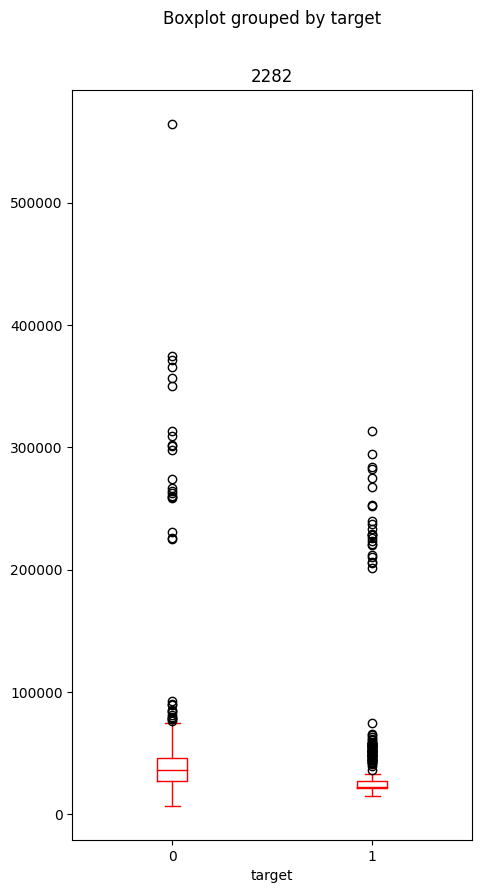

In [ ]:
df.boxplot(column=[2282], by='target', grid= False , color='red', figsize=(5, 10)) 